# Profiling

Run profiler: `python3 -m yappi -o profile.out Experiment.py`.

Analyze:

In [2]:
import pstats
stats = pstats.Stats('profile.out')
stats.strip_dirs().sort_stats('cumulative').print_stats(15)

# python3 -c "import pstats; stats = pstats.Stats('profile.out'); stats.strip_dirs().sort_stats('cumulative').print_stats(15)"

Sun Oct 14 14:30:21 2018    profile.out

         4176997 function calls (4235720 primitive calls) in 20.601 seconds

   Ordered by: cumulative time
   List reduced from 10513 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   84.303   42.151 threading.py:851(Thread.run)
        2    0.127    0.063   84.302   42.151 data_utils.py:632(GeneratorEnqueuer._data_generator_task)
       52    0.436    0.008   83.950    1.614 BatchGenerator.py:213(BatchGenerator.__next__)
      304    0.025    0.000   83.514    0.275 BatchGenerator.py:241(BatchGenerator.generate_patches)
      304    1.007    0.003   82.917    0.273 BatchGenerator.py:112(BatchGenerator.crop)
      304    0.488    0.002   81.892    0.269 Tools.py:7(get_voxel_of_rand_label)
      358    1.101    0.003   79.338    0.222 numeric.py:781(argwhere)
     1605    0.007    0.000   78.240    0.049 fromnumeric.py:50(_wrapfunc)
      359    0.002    0.000   6

# Experimentation

## Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import Datasets
import Metrics
import Tools

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)

brats12 = Datasets.BraTS12()
brainweb = Datasets.BrainWeb()
tumorsim = Datasets.TumorSim()
brainweb_brats12 = Datasets.MultiDataset([brainweb, brats12], tumorsim)
brainweb_brats12_ignore_bg = Datasets.MultiDataset([brainweb, brats12], ignore_backgrounds=True)
brats12_brainweb = Datasets.MultiDataset([brats12, brainweb], tumorsim)
brats12_brainweb_ignore_bg = Datasets.MultiDataset([brats12, brainweb], ignore_backgrounds=True)


mrbrains13 = Datasets.MRBrainS13()
mrbrains13_val = Datasets.MRBrainS13(validation_portion=1)
ibsr = Datasets.IBSR()
mrbrains17 = Datasets.MRBrainS17()
mrbrains18 = Datasets.MRBrainS18(validation_portion=1)
mrbrains17_ibsr = Datasets.MultiDataset([mrbrains17, ibsr], mrbrains18)
mrbrains17_13 = Datasets.MultiDataset([mrbrains17, mrbrains13], mrbrains18)

mrbrains17_ibsr = Datasets.MultiDataset([mrbrains17, ibsr], mrbrains18, balance='labels')
# mrbrains17_13 = Datasets.MultiDataset([mrbrains17, mrbrains13], mrbrains18, balance='labels')



Using TensorFlow backend.


## Metrics

In [2]:

def plot_full_volume_metrics(datasets, losses, subdir='balanced_dataset_metrics'):
    """Each dataset should have its respective loss. loss = None defaults to sparse_categorical_crossentropy"""
    Tools.set_model_subdir(subdir)
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    for dataset, loss in zip(datasets, losses):
        savedir = Tools.get_dataset_savedir(dataset, loss)
        data = np.load(savedir + '/full_volume_metrics.npz')['val']

        n_epochs, n_classes, n_metrics = data.shape
        assert(n_classes == dataset.n_classes - 1)

        metrics = ['accuracy', 'sensitivity', 'specificity', 'dice', 'jaccard', 'hausdorff', 
                   'contour mean distance'][:n_metrics]

        classes = dataset.classes[1:]

        data = data.reshape(n_epochs, n_classes * n_metrics)
        cols = pd.MultiIndex.from_product([classes, metrics], names=['class', 'metric'])
        df = pd.DataFrame(data, columns=cols)

        # df['Gray matter'].plot()
        label = '%s %s ' % (dataset.name, loss.__name__ if loss is not None else 'crossentropy')

        for cls in classes:
            df[(cls, 'dice')].plot(ax=ax, label=label + cls)

    plt.ylabel('dice')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
    
def plot_train_val_metrics(datasets_and_losses, subdir='balanced_dataset_metrics'):
    """Each dataset should have its respective loss. loss = None defaults to sparse_categorical_crossentropy.
    datasets_and_losses is a list of tuples (dataset, loss)."""
    Tools.set_model_subdir(subdir)
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    colors='rgbymc'
    for (dataset, loss), color in zip(datasets_and_losses, colors):
        savedir = Tools.get_dataset_savedir(dataset, loss)
        metrics = pd.read_csv(savedir + '/metrics.csv')
        
        label = '%s %s ' % (dataset.name, loss.__name__ if loss is not None else 'crossentropy')
        metrics['val_mean_dice_coef'].rolling(20).mean().plot(ax=ax, label=label + 'val', color=color, linewidth=3)
        metrics['mean_dice_coef'].rolling(10).mean().plot(ax=ax, label=label + 'train', style=':', color=color)
#         metrics.plot(ax=ax, y='val_dice_coef', label=label + 'val', style='--')
#         print(metrics['val_dice_coef'].rolling(20).mean())
#         metrics.plot(ax=ax, y='dice_coef', label=label + 'train')
    plt.ylabel('Dice')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()


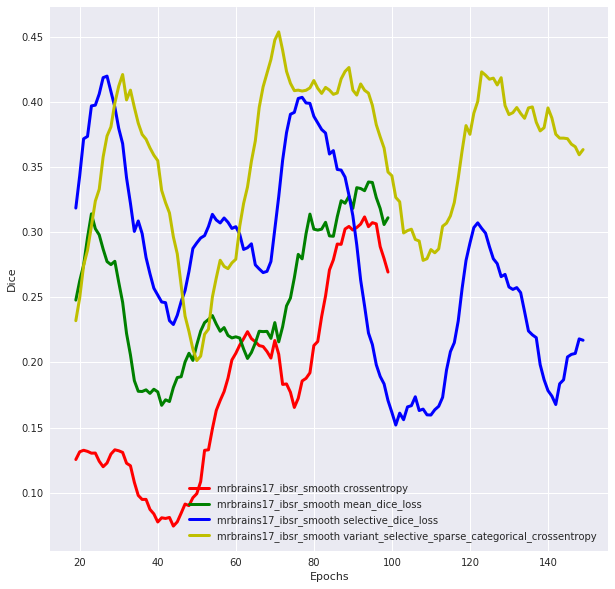

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Tools
sns.set()
def plot_val_metrics(dataset, losses, labels, subdir='balanced_dataset_metrics'):
    """Each dataset should have its respective loss. loss = None defaults to sparse_categorical_crossentropy.
    datasets_and_losses is a list of tuples (dataset, loss)."""
    Tools.set_model_subdir(subdir)
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    colors='rgbymc'
    for loss, color, label in zip(losses, colors, labels):
        savedir = Tools.get_dataset_savedir(dataset, loss)
        metrics = pd.read_csv(savedir + '/metrics.csv')
        
        label = '%s %s ' % (dataset.name, loss.__name__ if loss is not None else 'crossentropy')
        metrics['val_mean_dice_coef'].rolling(20).mean().plot(ax=ax, label=label, color=color, linewidth=3)
#         metrics['mean_dice_coef'].rolling(10).mean().plot(ax=ax, label=label + 'train', style=':', color=color)
#         metrics.plot(ax=ax, y='val_dice_coef', label=label + 'val', style='--')
#         print(metrics['val_dice_coef'].rolling(20).mean())
#         metrics.plot(ax=ax, y='dice_coef', label=label + 'train')
    plt.ylabel('Dice')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    
dataset = mrbrains17_ibsr
losses = [None, Metrics.mean_dice_loss, Metrics.selective_dice_loss, Metrics.variant_selective_sparse_categorical_crossentropy]
loss_labels = ['Entropia cruzada', 'Dice', 'Dice selectivo', 'Entropia cruzada selectiva']
plot_val_metrics(dataset, losses, loss_labels, subdir='smooth_metrics')

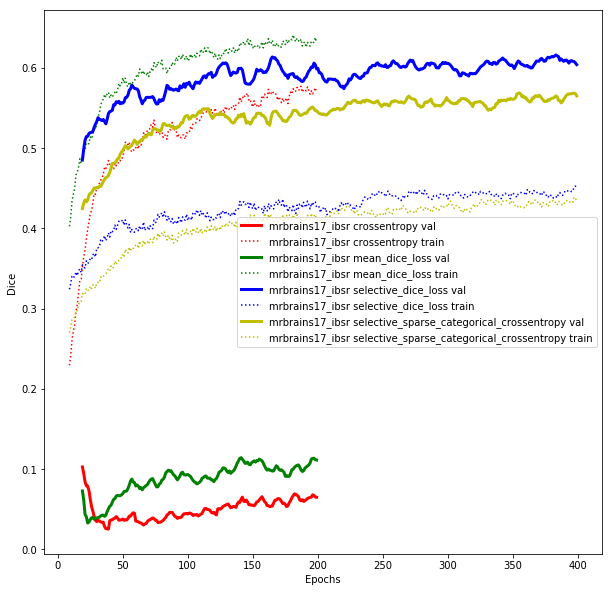

In [10]:
dataset = mrbrains17_ibsr
plot_train_val_metrics([(dataset, None),
#                         (dataset, Metrics.dice_loss), 
                        (dataset, Metrics.mean_dice_loss),
                        (dataset, Metrics.selective_dice_loss),
                        (dataset, Metrics.selective_sparse_categorical_crossentropy),
#                         (dataset, Metrics.crossentropy_dice),
#                         (dataset, Metrics.improved_selective_sparse_categorical_crossentropy)
                       ],
                       'balanced_datasets_metrics'
                      )

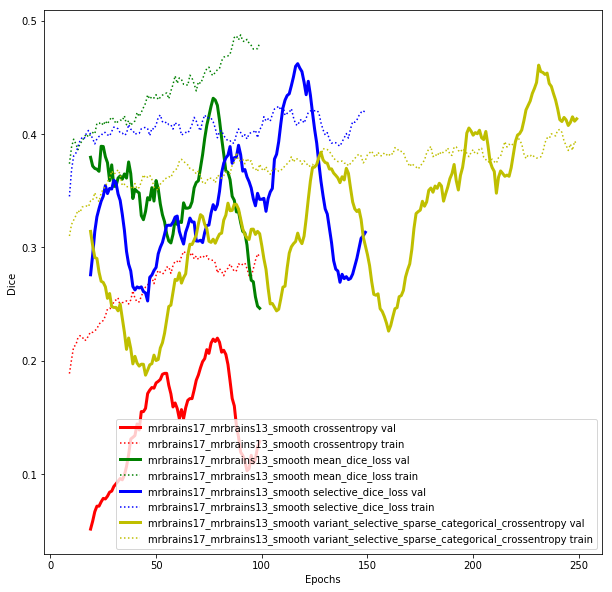

In [69]:
dataset = mrbrains17_13
# plot_full_volume_metrics([(dataset, None),
#                           (dataset, Metrics.dice_loss), 
#                           (dataset, Metrics.mean_dice_loss)])
plot_train_val_metrics([(dataset, None),
#                         (dataset, Metrics.dice_loss), 
                        (dataset, Metrics.mean_dice_loss),
                        (dataset, Metrics.selective_dice_loss),
                        (dataset, Metrics.variant_selective_sparse_categorical_crossentropy),
                       ],
                       'smooth_metrics'
                      )

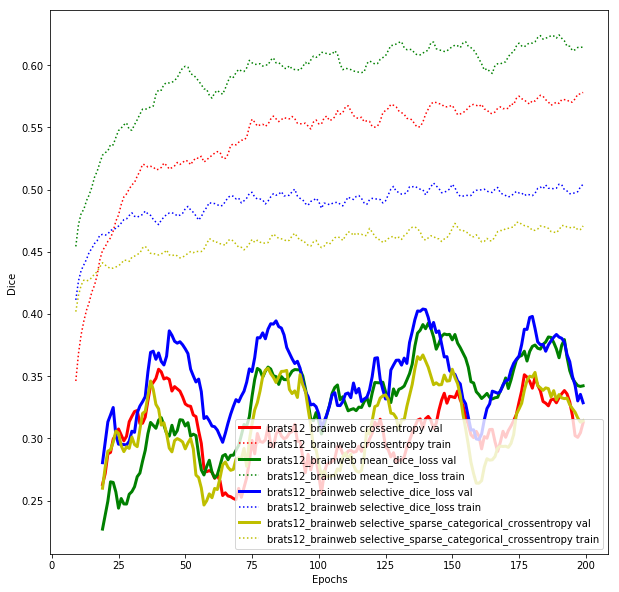

In [3]:
dataset = brats12_brainweb
# plot_full_volume_metrics([(dataset, None),
#                           (dataset, Metrics.dice_loss), 
#                           (dataset, Metrics.mean_dice_loss)])
plot_train_val_metrics([(dataset, None),
#                         (dataset, Metrics.dice_loss), 
                        (dataset, Metrics.mean_dice_loss),
                        (dataset, Metrics.selective_dice_loss),
                        (dataset, Metrics.selective_sparse_categorical_crossentropy),
                        #(dataset, Metrics.bg_selective_sparse_categorical_crossentropy),
                       ],
                       'no_vessels_metrics'
                      )

## Comparison between Single task UNet, MultiUNet and Multi task Unets

In [29]:
# Boxplot version
import pandas as pd
import seaborn as sns

def load_data(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir, savefile=''):
    Tools.set_model_subdir(subdir)
    
#     lesion_metrics = pd.read_csv('%s/validation_metrics.csv' % Tools.get_dataset_savedir(lesion_dataset))
#     print('%s/validation_metrics.csv' % Tools.get_dataset_savedir(lesion_dataset))
#     anatomical_metrics = pd.read_csv('%s/validation_metrics.csv' % Tools.get_dataset_savedir(anatomical_dataset))
#     single_task_metrics = lesion_metrics.append(anatomical_metrics)
    multiunet_metrics = pd.read_csv('%s/validation_metrics_%s.csv' % (Tools.get_dataset_savedir(mixed_dataset), multidataset.name))
    crossentropy_metrics = pd.read_csv('%s/validation_metrics_%s.csv' % (Tools.get_dataset_savedir(multidataset), mixed_dataset.name))
    mean_dice_metrics = pd.read_csv('%s/validation_metrics_%s.csv' % (Tools.get_dataset_savedir(multidataset, loss=Metrics.mean_dice_loss), mixed_dataset.name))
#     selective_dice_metrics = pd.read_csv('%s/validation_metrics_%s.csv' % (Tools.get_dataset_savedir(multidataset, loss=Metrics.selective_dice_loss), mixed_dataset.name))
    selective_crossentropy_metrics = pd.read_csv('%s/validation_metrics_%s.csv' % (Tools.get_dataset_savedir(multidataset, loss=Metrics.variant_selective_sparse_categorical_crossentropy), mixed_dataset.name))
#     bg_selective_crossentropy_metrics = pd.read_csv('%s/validation_metrics_%s.csv' % (Tools.get_dataset_savedir(multidataset,loss=Metrics.bg_selective_sparse_categorical_crossentropy),mixed_dataset.name))
    
    return pd.concat([#single_task_metrics, 
                      multiunet_metrics, 
                      crossentropy_metrics, 
                      selective_crossentropy_metrics, 
#                       bg_selective_crossentropy_metrics, 
                      mean_dice_metrics, 
#                       selective_dice_metrics
                     ])

translator = {
    'Single task': 'Mono-tarea',
    'MultiUNet': 'MultiUNet',
    'Crossentropy' : 'Entropia cruzada',
    'Selective crossentropy' : 'Entropia cruzada selectiva',
    'Mean dice' : 'Dice',
    'Selective dice' : 'Dice selectivo',
    
    'white matter' : 'wm',
    'gray matter' : 'gm',
}
def translate(x):
    try:
        return translator[x]
    except KeyError:
        return x

def translate_df(df):
    # Translate
    df['Funcion de costo'] = df.apply(lambda row: translate(row['Loss function']), axis=1)
    df['Loss function'] = df.apply(lambda row: translate(row['Loss function']), axis=1)
    df['Clase'] = df.apply(lambda row: translate(row['Class']), axis=1)
    df['Class'] = df.apply(lambda row: translate(row['Class']), axis=1)

    
def make_boxplot(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir, title, savefile='', metric='Dice', figsize=(16, 8)):
    df = load_data(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir)
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         print(df)
#     translate_df(df)
    
    plt.figure(figsize=figsize, dpi=200)
#     plot = sns.boxplot(x='Clase', y=metric, data=df.reset_index(), hue='Funcion de costo', palette='Set2')
    df['Loss function'][df['Loss function'] == 'Mean dice'] = 'Dice'
    plot = sns.boxplot(x='Class', y=metric, data=df.reset_index(), hue='Loss function', palette='Set2')
    plt.legend(loc='center right')
    plot.set_title(title)
    plt.ylim((0, 1))
    if savefile:
        plot.get_figure().savefig(savefile, bbox_inches='tight')


smooth_metrics


/home/nico/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


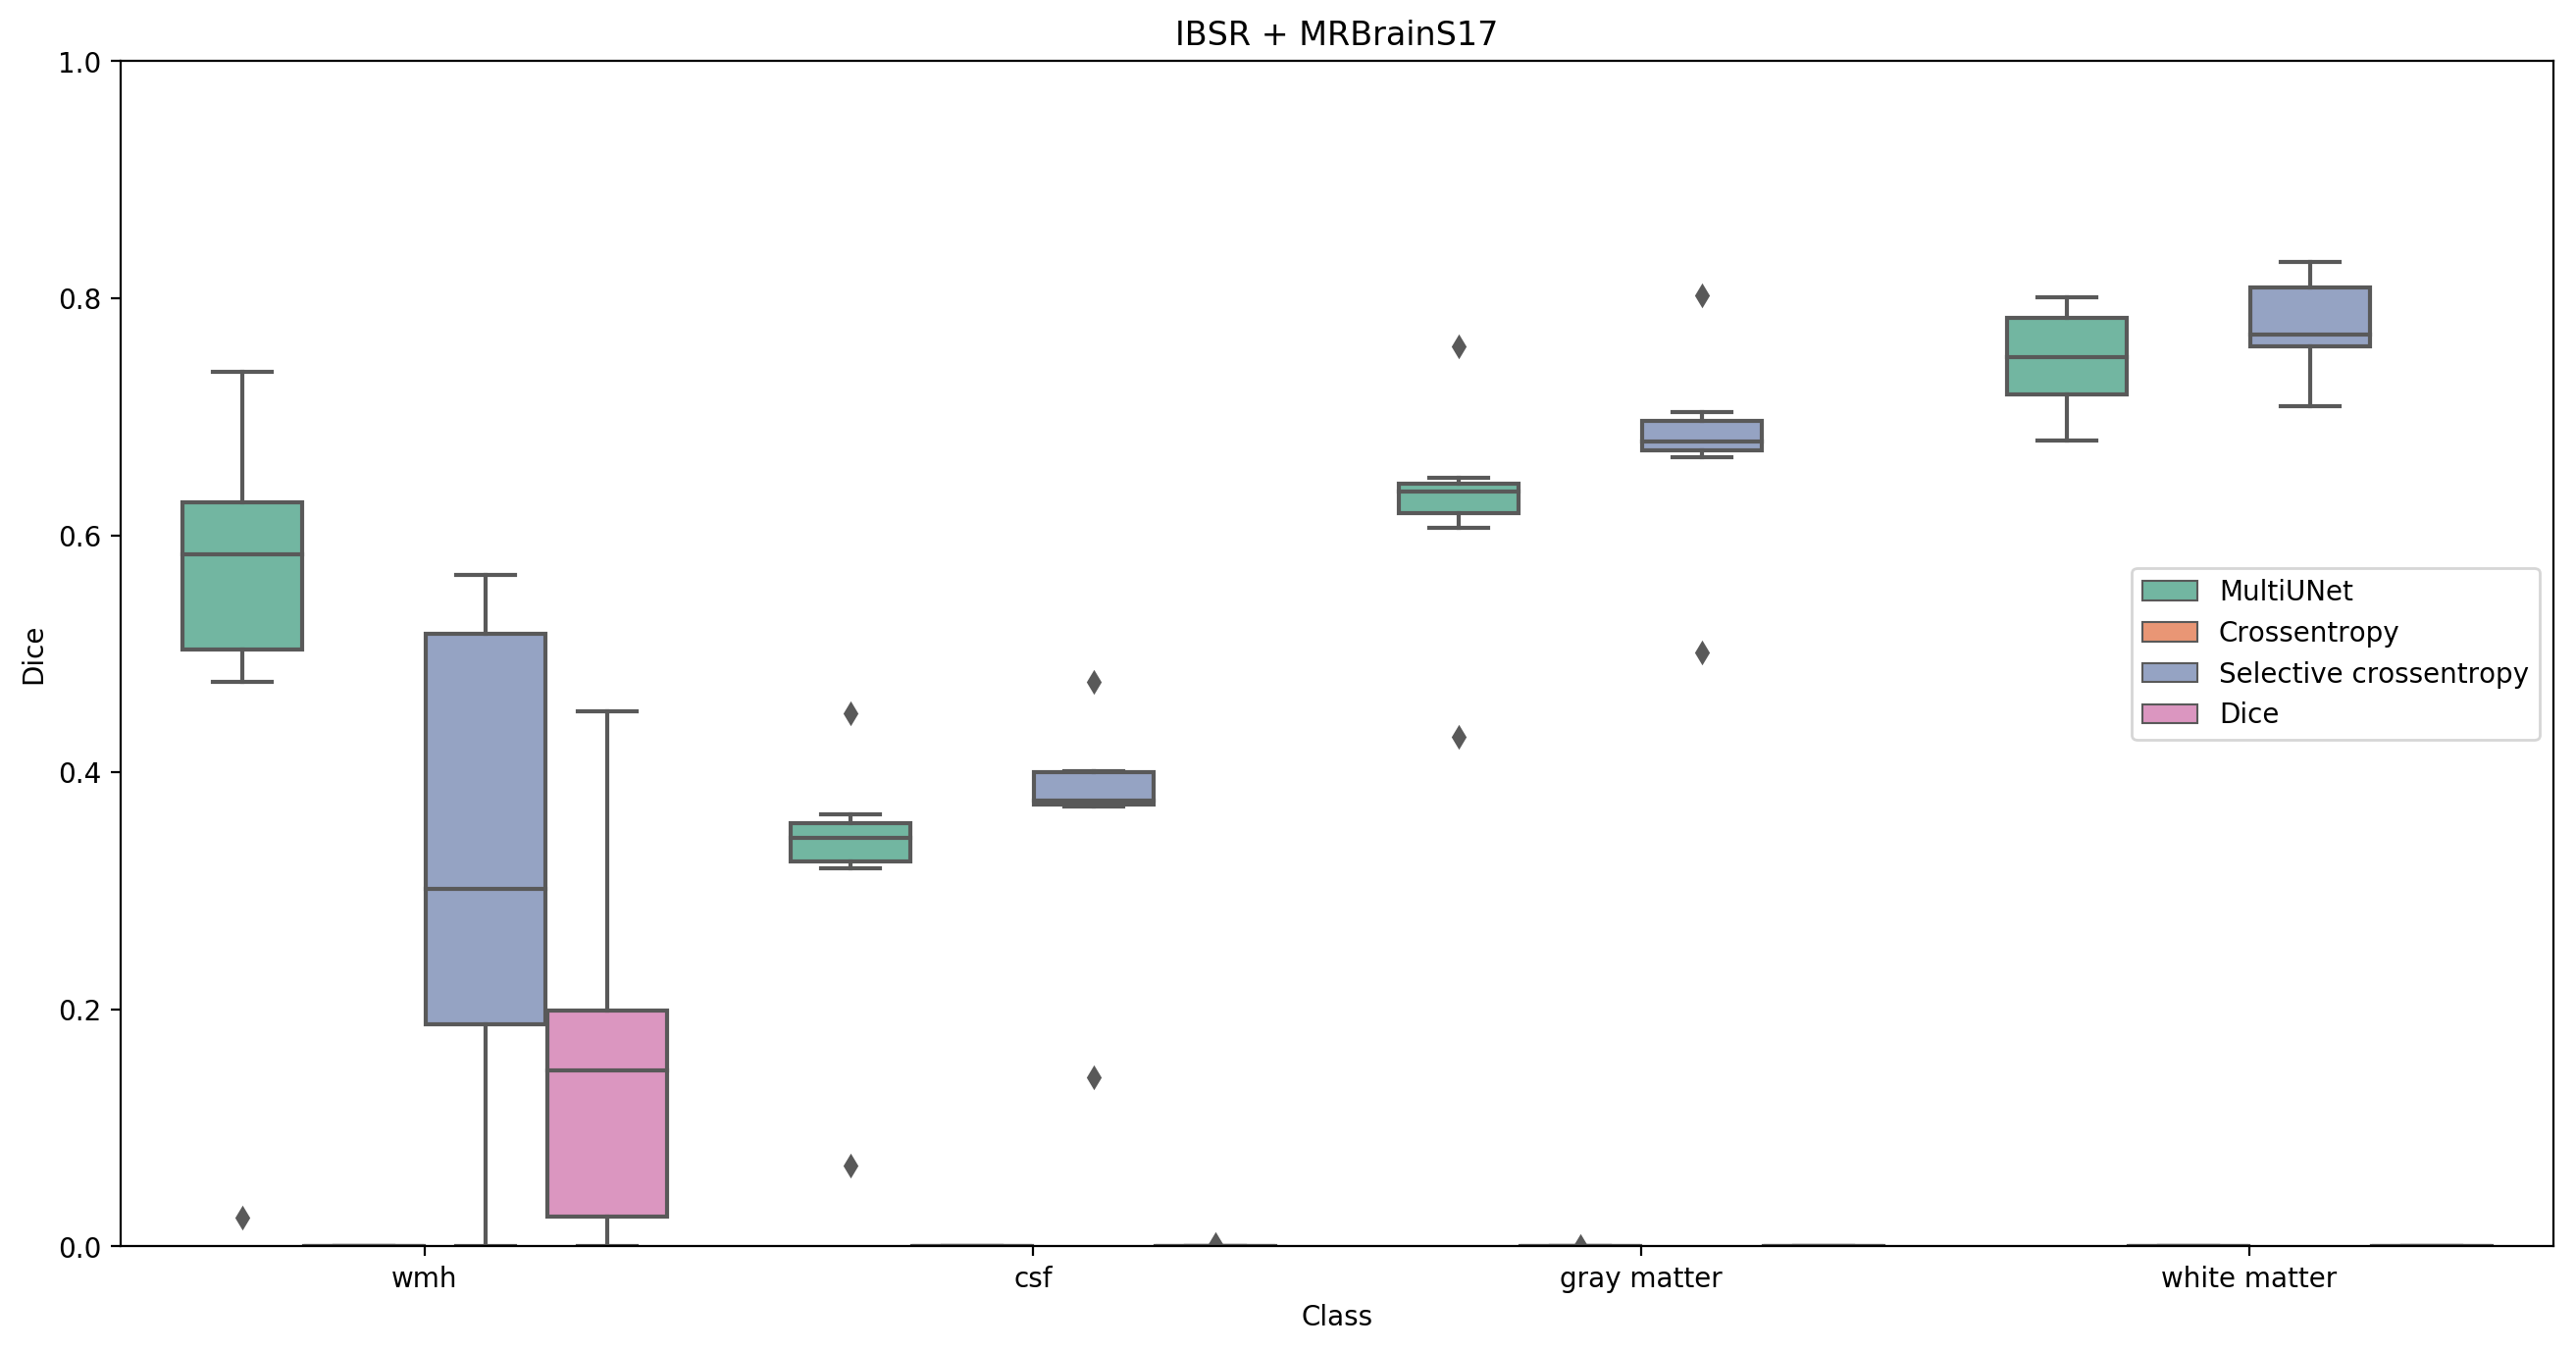

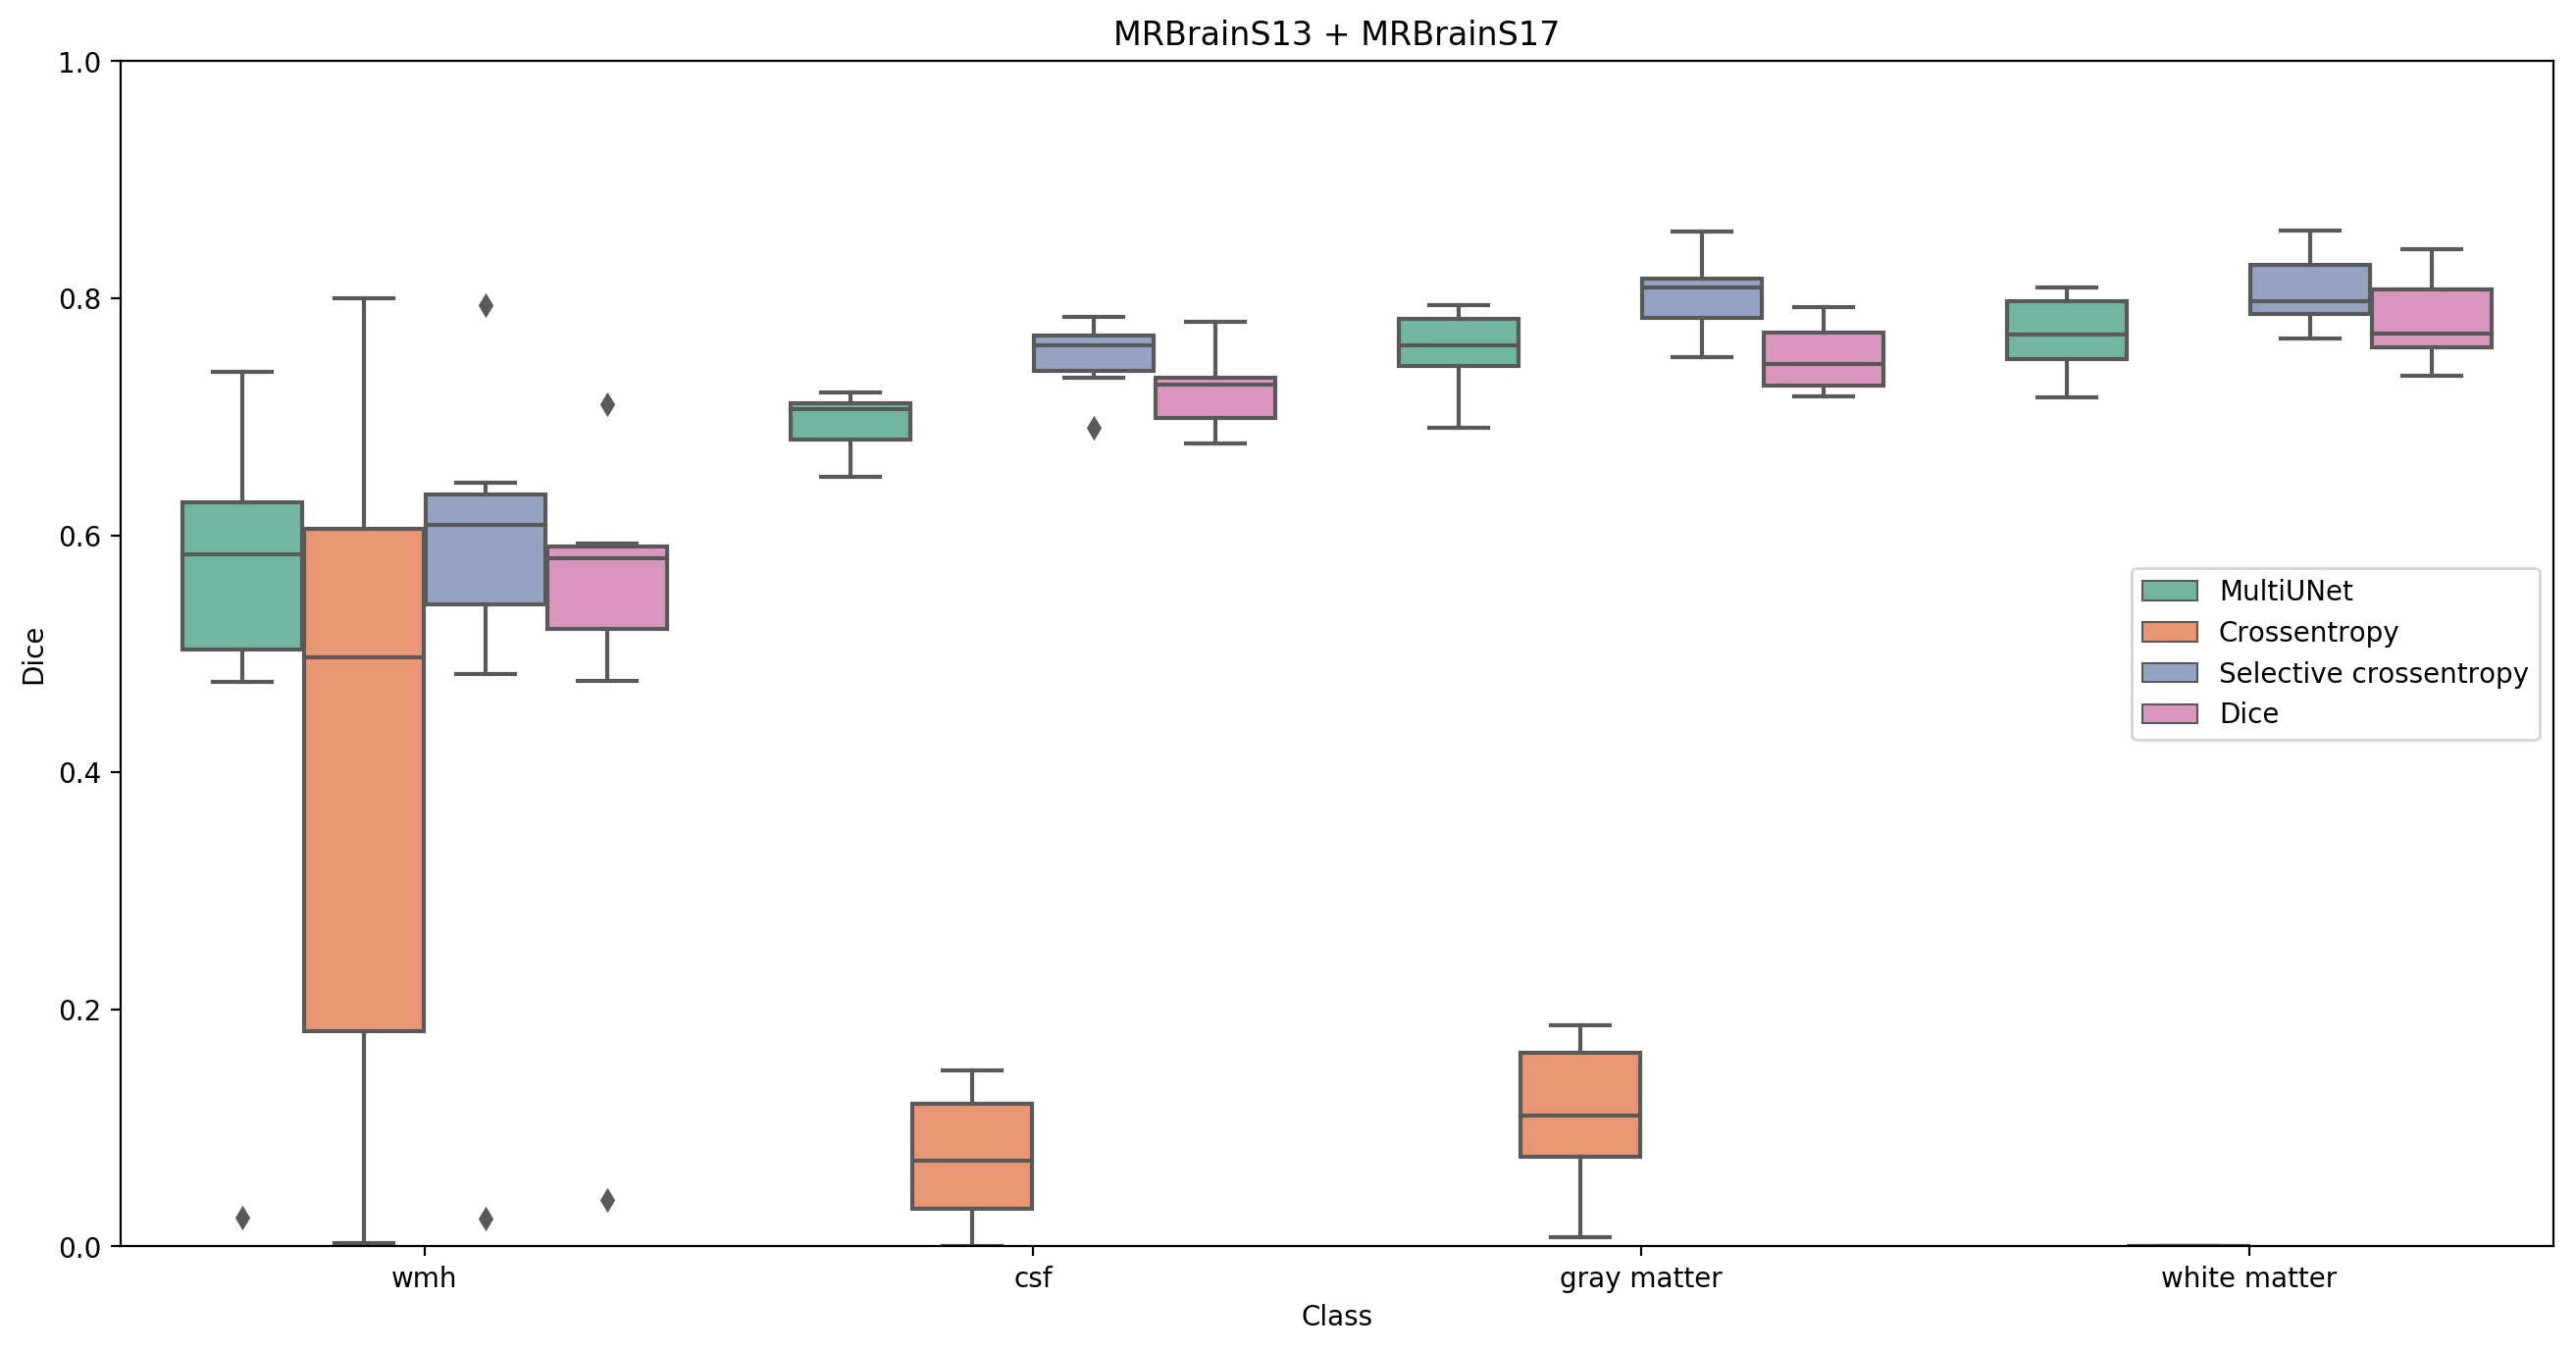

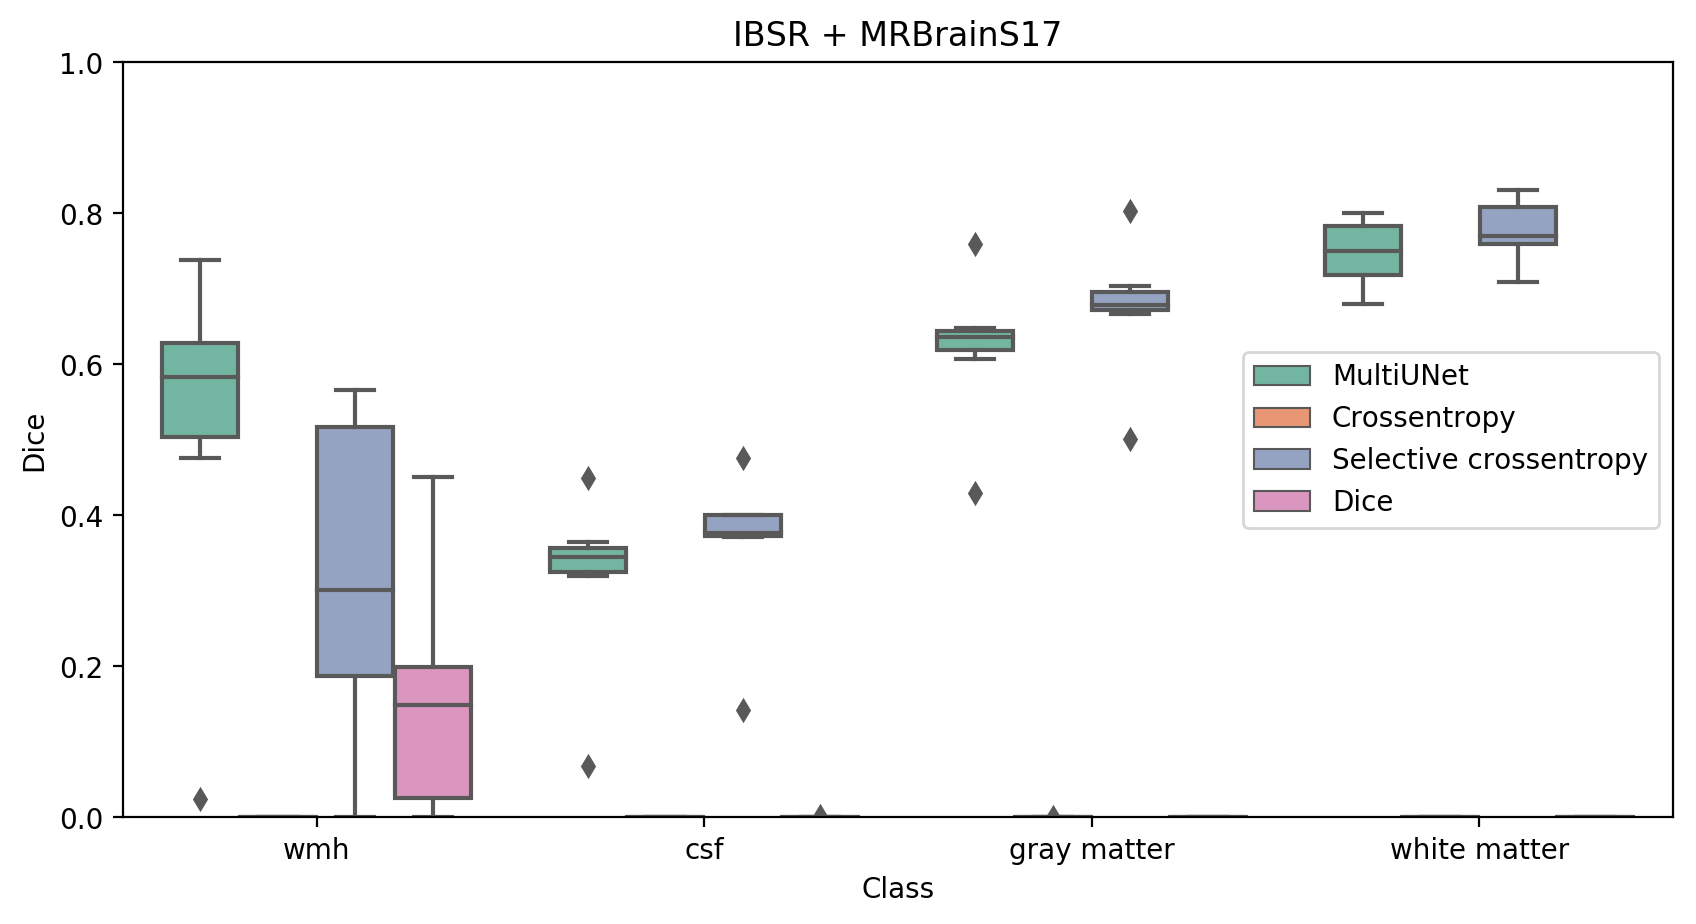

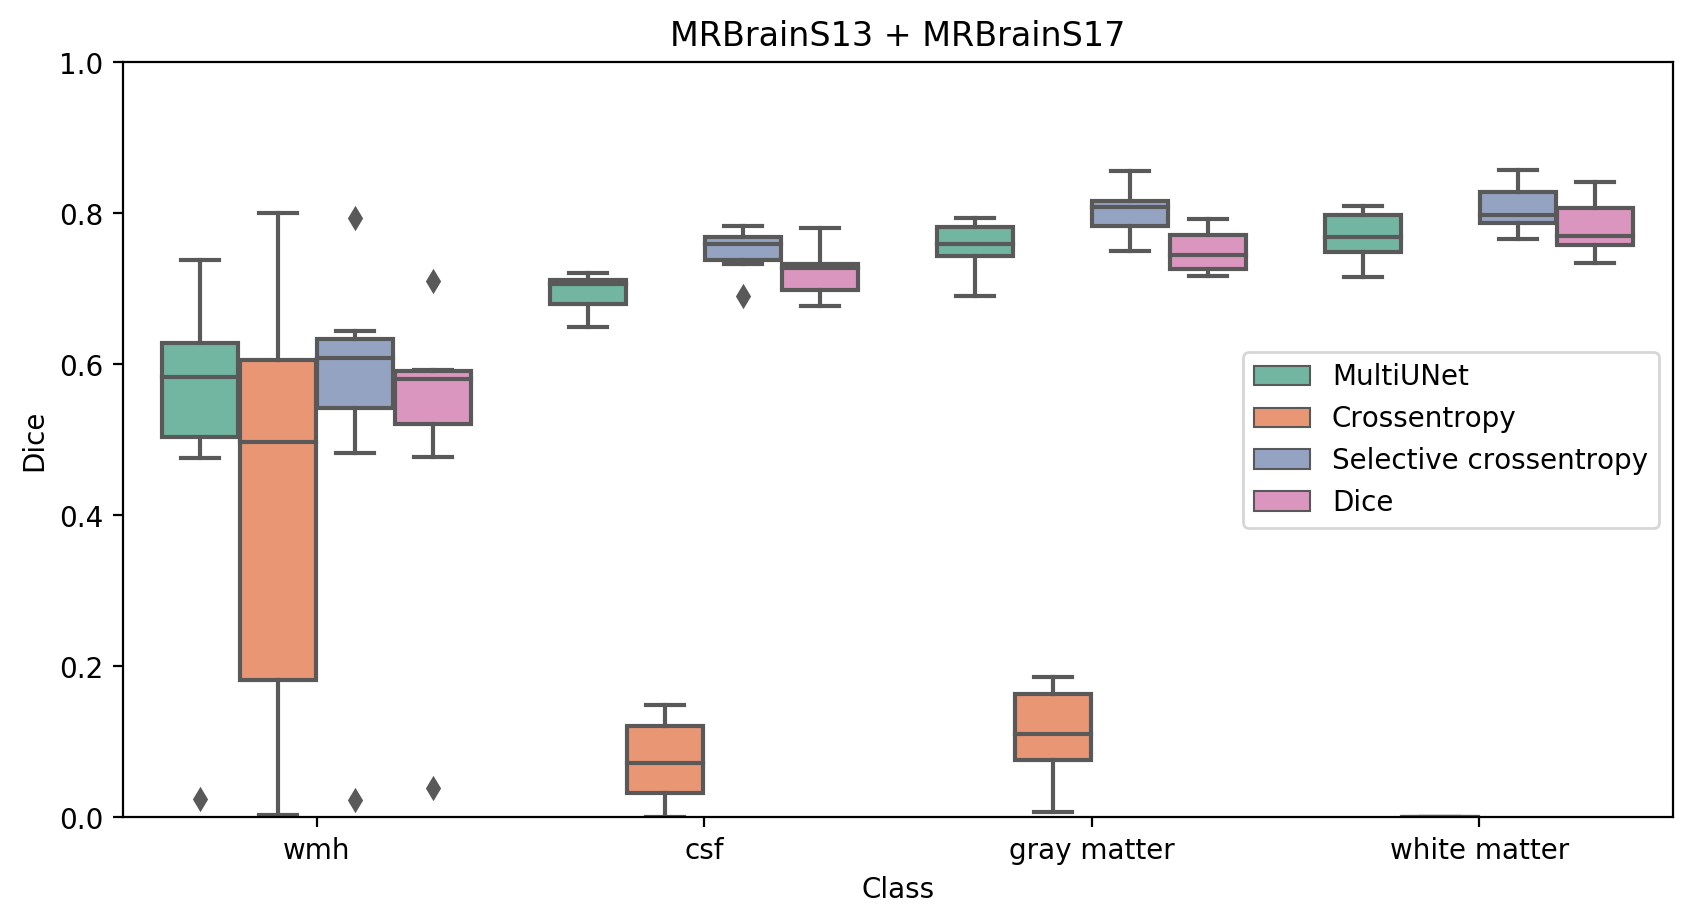

In [30]:
save = True
print('smooth_metrics')
make_boxplot(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'smooth_metrics', 'IBSR + MRBrainS17', savefile=save and '../../paper/plots/boxplots/small_font/mrbrains17_ibsr.png')
make_boxplot(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'smooth_metrics', 'MRBrainS13 + MRBrainS17', savefile=save and '../../paper/plots/boxplots/small_font/mrbrains17_mrbrains13.png')

make_boxplot(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'smooth_metrics', 'IBSR + MRBrainS17', savefile=save and '../../paper/plots/boxplots/large_font/mrbrains17_ibsr.png', figsize=(10,5))
make_boxplot(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'smooth_metrics', 'MRBrainS13 + MRBrainS17', savefile=save and '../../paper/plots/boxplots/large_font/mrbrains17_mrbrains13.png', figsize=(10,5))

# print('old_normalization_metrics')
# make_boxplot(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'old_normalization_metrics', savefile=save and '../plots/boxplots/old_normalization_mrbrains17_ibsr.png')
# make_boxplot(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'old_normalization_metrics', savefile=save and '../plots/boxplots/old_normalization_mrbrains17_13.png')

# print('balanced_labels_metrics')
# make_boxplot(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'balanced_labels_metrics', savefile=save and '../plots/boxplots/balanced_labels_mrbrains17_ibsr.png')
# make_boxplot(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'balanced_labels_metrics')

/home/nico/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


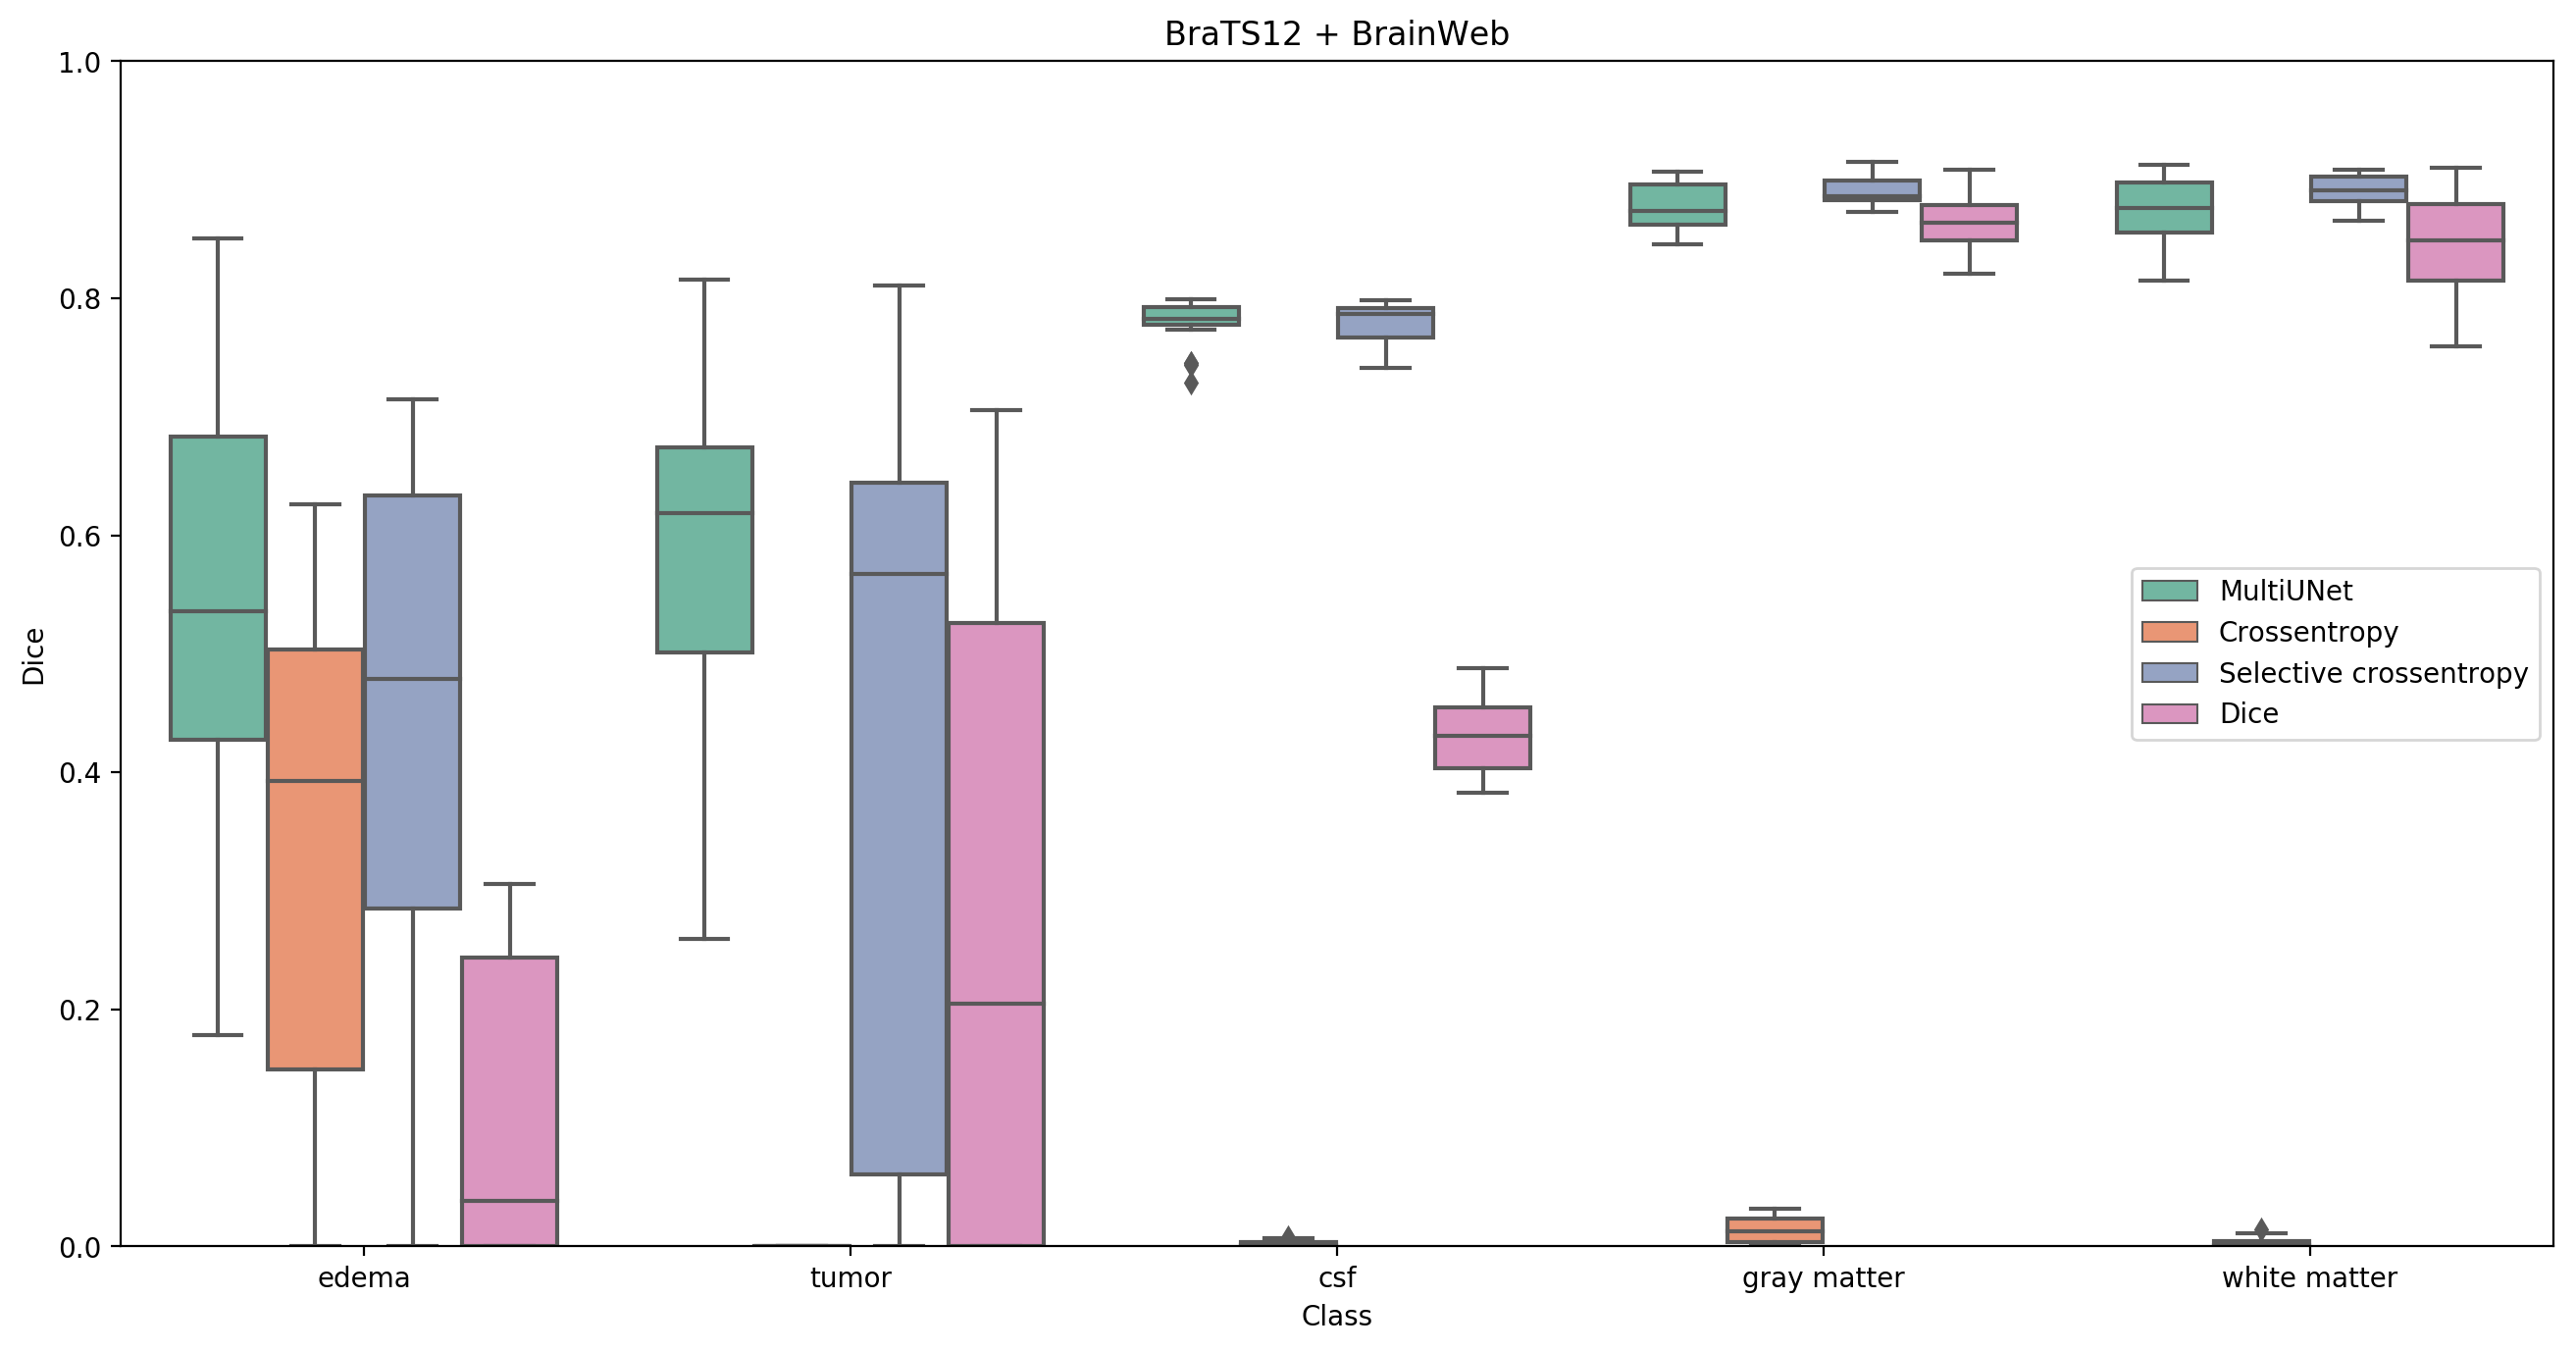

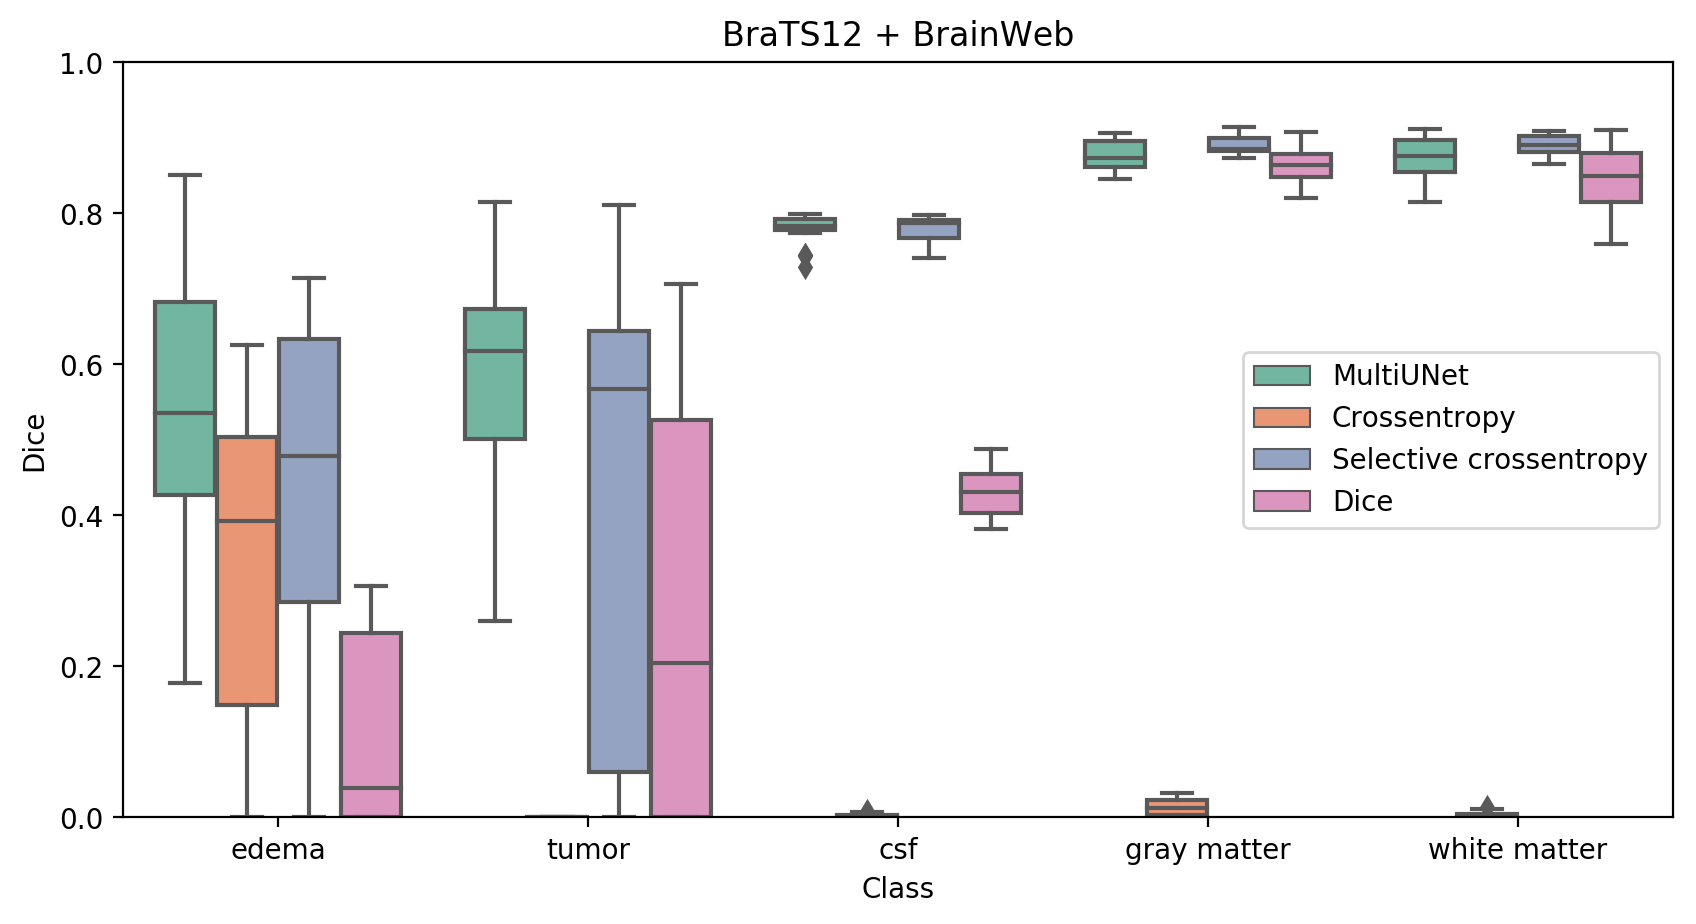

In [39]:
save = True
# make_boxplot(brainweb, brats12, brainweb_brats12, tumorsim, 'balanced_datasets_metrics', savefile=save and '../plots/boxplots/balanced_datasets_brainweb_brats12.png')


# make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'balanced_datasets_metrics', savefile=save and '../plots/boxplots/balanced_datasets_brainweb_brats12.png')

make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'final_metrics/tumors', 'BraTS12 + BrainWeb', savefile=save and '../../paper/plots/boxplots/small_font/brats12_brainweb.png')
make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'final_metrics/tumors', 'BraTS12 + BrainWeb', savefile=save and '../../paper/plots/boxplots/large_font/brats12_brainweb.png', figsize=(10,5))
# make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'final_metrics/tumors', 'BraTS12 + BrainWeb', metric='Sensitivity')
# make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'final_metrics/tumors', 'BraTS12 + BrainWeb', metric='Specificity')


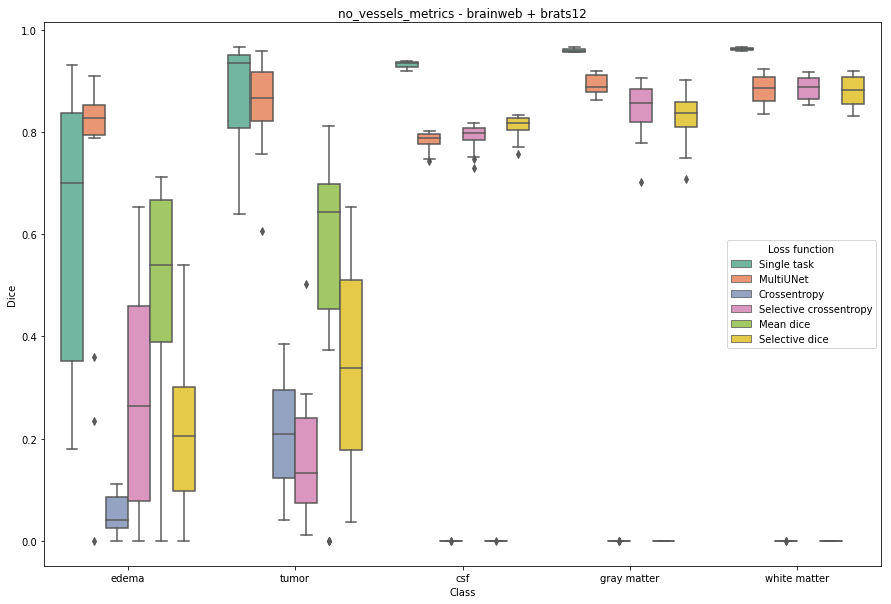

In [5]:
save = False
# make_boxplot(brainweb, brats12, brainweb_brats12, tumorsim, 'balanced_datasets_metrics', savefile=save and '../plots/boxplots/balanced_datasets_brainweb_brats12.png')


# make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'balanced_datasets_metrics', savefile=save and '../plots/boxplots/balanced_datasets_brainweb_brats12.png')

make_boxplot(brainweb, brats12, brats12_brainweb, tumorsim, 'no_vessels_metrics', savefile=save and '../plots/boxplots/no_vessels_brats12_brainweb.png')

In [36]:
# Boxplot version
import pandas as pd
import seaborn as sns

def load_singletask_data(dataset, subdir):
    Tools.set_model_subdir(subdir)
    print('%s/validation_metrics.csv' % (Tools.get_dataset_savedir(dataset)))
    crossentropy_metrics = pd.read_csv('%s/validation_metrics.csv' % (Tools.get_dataset_savedir(dataset)))
    mean_dice_metrics = pd.read_csv('%s/validation_metrics.csv' % (Tools.get_dataset_savedir(dataset, loss=Metrics.mean_dice_loss)))
#     selective_dice_metrics = pd.read_csv('%s/validation_metrics.csv' % (Tools.get_dataset_savedir(dataset, loss=Metrics.selective_dice_loss)))
    selective_crossentropy_metrics = pd.read_csv('%s/validation_metrics.csv' % (Tools.get_dataset_savedir(dataset, loss=Metrics.variant_selective_sparse_categorical_crossentropy)))
    
    return pd.concat([crossentropy_metrics, 
                      selective_crossentropy_metrics, 
                      mean_dice_metrics, 
#                       selective_dice_metrics
                     ])



def make_singletask_boxplot(dataset, subdir, title, savefile=''):
    df = load_singletask_data(dataset, subdir)
#     translate_df(df)
    
    plt.figure(figsize=(2, 4))
    plot = sns.boxplot(x='Clase', y='Dice', data=df, hue='Funcion de costo', palette='Set2')
#     plt.legend(loc='lower right')
    plot.get_legend().remove()
    plot.set_title(title)
    plt.ylim((0, 1))
#     if savefile:
#         plot.get_figure().savefig(savefile, bbox_inches='tight')


../models/singletask_metrics/brats12/unet_brats12/validation_metrics.csv
../models/singletask_metrics/ibsr_more_val/unet_ibsr_smooth/validation_metrics.csv
../models/singletask_metrics/mrbrains17/unet_mrbrains17/validation_metrics.csv


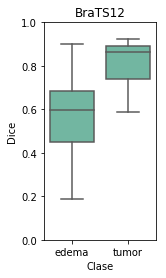

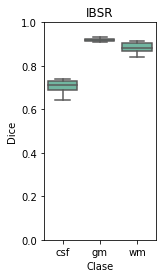

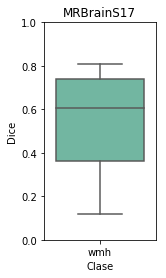

In [31]:
make_singletask_boxplot(brats12, 'singletask_metrics/brats12', 'BraTS12')

make_singletask_boxplot(ibsr, 'singletask_metrics/ibsr_more_val', 'IBSR')

# make_singletask_boxplot(mrbrains13, 'singletask_metrics/mrbrains13', 'MRBrainS13')

make_singletask_boxplot(mrbrains17, 'singletask_metrics/mrbrains17', 'MRBrainS17')


# Statistic tests

## Wilcoxon signed rank test
To test whether the mean of two paired samples differs.

../models/singletask_metrics/ibsr_more_val/unet_ibsr_smooth/validation_metrics.csv
../models/singletask_metrics/brats12/unet_brats12/validation_metrics.csv
../models/singletask_metrics/mrbrains17/unet_mrbrains17/validation_metrics.csv
  dataset             loss1                       loss2  statistic    pvalue  significant
0    IBSR              Dice            Entropia cruzada       12.0  0.000321         True
1    IBSR              Dice  Entropia cruzada selectiva        9.0  0.000214         True
2    IBSR  Entropia cruzada  Entropia cruzada selectiva        2.0  0.000080         True


/home/nico/.local/lib/python3.5/site-packages/scipy/stats/morestats.py:2388: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/nico/.local/lib/python3.5/site-packages/scipy/stats/morestats.py:2389: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


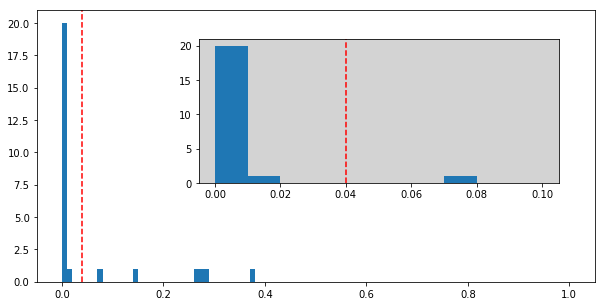

In [37]:
from scipy.stats import wilcoxon
import Orange
import itertools
import networkx as nx

# Tools.set_model_subdir('singletask_metrics_nobg/brats12')
# def compute_wilcoxon(train_dataset, val_dataset, loss1, loss2):
#     path1 = '%s/validation_metrics%s.csv' % (Tools.get_dataset_savedir(train_dataset, loss=loss1), '_%s' % (val_dataset.name) if val_dataset else '')
#     path2 = '%s/validation_metrics%s.csv' % (Tools.get_dataset_savedir(train_dataset, loss=loss2), '_%s' % (val_dataset.name) if val_dataset else '')
    
#     data1 = pd.read_csv(path1)
#     data2 = pd.read_csv(path2)
#     print(data1)
# #     print(data2)
#     join = data1.merge(data2, on=['Path', 'Class'])[['Path', 'Class', 'Dice_x', 'Loss function_x', 'Dice_y', 'Loss function_y']]
#     loss_x = join['Loss function_x'].unique()
#     loss_y = join['Loss function_y'].unique()
#     for label in join['Class'].unique():
#         label_data = join[join['Class'] == label]
#         stat = wilcoxon(label_data['Dice_x'], label_data['Dice_y'])
#         print('Wilcoxon for', train_dataset.name, (val_dataset or '') and 'on %s' % val_dataset.name, 'with loss functions', loss_x, loss_y, 'on label', label)
#         print(stat)
    
# compute_wilcoxon(brats12, None, Metrics.variant_selective_sparse_categorical_crossentropy, Metrics.selective_dice_loss)

def wilc(df, loss1, loss2):
#     print(df.columns)
    join = df[df['Loss function'] == loss1].merge(df[df['Loss function'] == loss2], on=['Image', 'Class'])[['Image', 'Class', 'Dice_x', 'Loss function_x', 'Dice_y', 'Loss function_y']]
#     print(df)
    stat = wilcoxon(join['Dice_x'], join['Dice_y'])
#     print(title, 'Loss 1:', loss1, 'Loss 2:', loss2)
#     print(stat)
    return stat
#     diff = join['Dice_x'] - join['Dice_y']
#     ax = diff.plot(kind='density')
#     mean_val = np.mean(ax.get_children()[0]._x)
#     plt.axvline(mean_val, linestyle='dashed', linewidth=2)
#     plt.xlim((-1, 1))
#     plt.title(title)
#     plt.show()

def sig_graph(df, title):
    # wilc_multitask(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'smooth_metrics', 'MRBrainS13 + MRBrainS17', 'Selective crossentropy', 'MultiUNet')
    # wilc_multitask(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'smooth_metrics', 'IBSR + MRBrainS17', 'Selective crossentropy', 'MultiUNet')
    # wilc_multitask(brainweb, brats12, brats12_brainweb, tumorsim, 'final_metrics', 'BrainWeb + BraTS12', 'Selective crossentropy', 'MultiUNet')
#     translate_df(df)
    df['Loss function'][df['Loss function'] == 'Mean dice'] = 'Dice'
    
    df = df[df['Loss function'] != 'Single-task']
    pval_significance = 0.05
    g = nx.Graph()

    avranks = df.groupby('Loss function').mean()['Dice']
#     print(avranks)
    losses = list(df.groupby('Loss function').mean().index)

#     losses = list(df['Loss function'].unique())
#     print(losses)
    # g.add_nodes_from(metrics)
    for loss1, loss2 in itertools.combinations(losses, 2):
        stat = wilc(df, loss1, loss2)
#         print(loss1, loss2, stat)
        if stat.pvalue > pval_significance:
            g.add_edge(losses.index(loss1), losses.index(loss2))
    not_sig = list(nx.find_cliques(g))
#     print(not_sig)
#     not_sig_pairs = [list(itertools.combinations(x, 2)) for x in not_sig]
#     print(not_sig_pairs)

    graph_ranks(avranks, losses, not_sig, lowv=round(min(avranks)-.05, 1), highv=round(max(avranks)+.1, 1), cd=0.5, width=6)
    plt.title(title)
    

def sig_graph_multitask(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir, title):
    df = load_data(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir).rename(columns={'Unnamed: 0': 'Image'})
    return sig_graph(df, title)
    
def sig_graph_singletask(dataset, subdir, title):
    df = load_singletask_data(dataset, subdir).rename(columns={'Unnamed: 0': 'Image'})
#     translate_df(df)
    return sig_graph(df, title)

def get_pvals(df, title):
#     translate_df(df)
    df = df[df['Loss function'] != 'Single-task']
    losses = list(df.groupby('Loss function').mean().index)
    stats = []
    for loss1, loss2 in itertools.combinations(losses, 2):
        stat = wilc(df, loss1, loss2)
        stats.append((title, loss1, loss2, stat.statistic, stat.pvalue))
    stats_df = pd.DataFrame(stats, columns=['dataset', 'loss1', 'loss2', 'statistic', 'pvalue'])
    return stats_df

def get_pvals_singletask(dataset, subdir, title):
    df = load_singletask_data(dataset, subdir).rename(columns={'Unnamed: 0': 'Image'})
    return get_pvals(df, title)

def get_pvals_multitask(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir, title):
    df = load_data(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir).rename(columns={'Unnamed: 0': 'Image'})
    return get_pvals(df, title)

singletask_sources = [(ibsr, 'singletask_metrics/ibsr_more_val', 'IBSR'),
                      (brats12, 'singletask_metrics/brats12', 'BraTS12'),
                      (mrbrains17, 'singletask_metrics/mrbrains17', 'MRBrainS17')]
multitask_sources = [(brainweb, brats12, brats12_brainweb, tumorsim, 'final_metrics/tumors', 'BraTS12 + BrainWeb'),
                     (ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'smooth_metrics', 'IBSR + MRBrainS17'),
                     (mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'smooth_metrics', 'MRBrainS13 + MRBrainS17')]

pvals_df = pd.concat([get_pvals_singletask(*params) for params in singletask_sources] +
                    [get_pvals_multitask(*params) for params in multitask_sources])
pvals_df['significant'] = pvals_df['pvalue'] < (0.05 / 3)

print(pvals_df[pvals_df['dataset'] == 'IBSR'])
# print((pvals_df['pvalue']).count())
# print((pvals_df[pvals_df['pvalue'] > 0.1]).count())
# print(pvals_df)
# print(get_pvals_singletask(ibsr, 'singletask_metrics/ibsr', 'IBSR'))
# print(get_pvals_multitask(*multitask_sources[0]))


# sig_graph_multitask(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'smooth_metrics', 'IBSR + MRBrainS17')


# sig_graph_singletask(ibsr, 'singletask_metrics/ibsr', 'IBSR')
# sig_graph_singletask(mrbrains17, 'singletask_metrics/mrbrains17', 'MRBrainS17')
# sig_graph_singletask(brats12, 'singletask_metrics/brats12', 'BraTS12')
# sns.set()
plt.figure(figsize=(10,5))
plt.hist(pvals_df['pvalue'], bins=100, range=(0, 1))
plt.axvline(x=0.04, color='r', linestyle='--')
a = plt.axes([.35, .4, .5, .4], facecolor='lightgray')
plt.hist(pvals_df['pvalue'], bins=10, range=(0, 0.1))
plt.axvline(x=0.04, color='r', linestyle='--')
plt.show()

/home/nico/.local/lib/python3.5/site-packages/scipy/stats/morestats.py:2388: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/home/nico/.local/lib/python3.5/site-packages/scipy/stats/morestats.py:2389: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


lines [[2, 3]]
lines [[2, 3]]
lines [[1, 2]]
../models/singletask_metrics/ibsr_more_val/unet_ibsr_smooth/validation_metrics.csv
lines []
../models/singletask_metrics/brats12/unet_brats12/validation_metrics.csv
lines [[0, 2], [1, 2], [0, 1]]
../models/singletask_metrics/mrbrains17/unet_mrbrains17/validation_metrics.csv
lines []


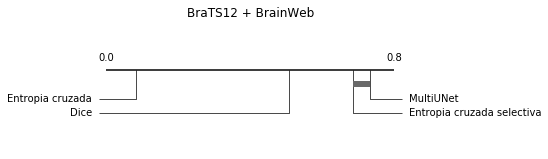

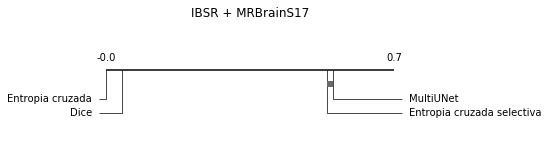

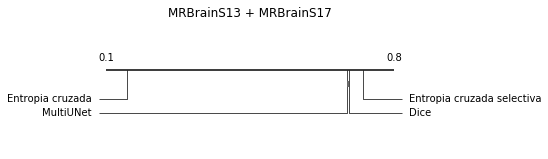

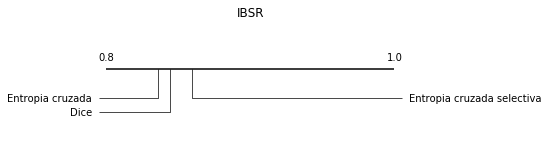

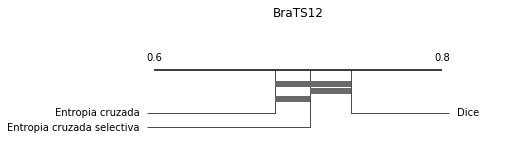

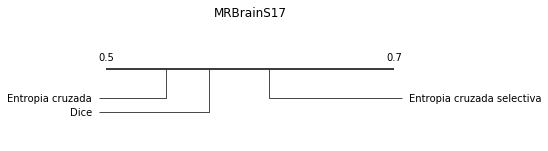

In [9]:
for params in multitask_sources:
    sig_graph_multitask(*params)
for params in singletask_sources:
    sig_graph_singletask(*params)


# sig_graph_singletask(ibsr, 'singletask_metrics/ibsr', 'IBSR')
# sig_graph_singletask(mrbrains17, 'singletask_metrics/mrbrains17', 'MRBrainS17')
# sig_graph_singletask(brats12, 'singletask_metrics/brats12', 'BraTS12')

In [6]:
import math
def graph_ranks(avranks, names, not_sig, lowv=None, highv=None,
                width=6, cd=0.5, cdmethod=None, textspace=1, reverse=False, filename=None, draw_sig=True, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]
    nnot_sig = [[sortidx.index(x) for x in l] for l in not_sig]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    # get pairs of non significant methods

#     lines = get_lines(ssums, cd)
#     lines = [(min(clique), max(clique)) for clique in nnot_sig]
    lines = [sorted(y) for x in nnot_sig for y in list(itertools.combinations(x, 2)) ]
    print('lines', lines)
    linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

    # add scale
    distanceh = 0.25
    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, solid_capstyle='butt', **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=1.5)

    bigtick = 0.1
    smalltick = 0.05

    tick = bigtick
#     for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
#         tick = smalltick
#         if a == int(a):
#             tick = bigtick
#         line([(rankpos(a), cline - tick / 2),
#               (rankpos(a), cline)],
#              linewidth=0.7)

    for a in (lowv, highv):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")
    if draw_sig:
        if cd and cdmethod is None:
            # upper scale
            if not reverse:
                begin, end = rankpos(lowv), rankpos(lowv + cd)
            else:
                begin, end = rankpos(highv), rankpos(highv - cd)

    #         line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
    #         line([(begin, distanceh + bigtick / 2),
    #               (begin, distanceh - bigtick / 2)],
    #              linewidth=0.7)
    #         line([(end, distanceh + bigtick / 2),
    #               (end, distanceh - bigtick / 2)],
    #              linewidth=0.7)
    #         text((begin + end) / 2, distanceh - 0.05, "CD",
    #              ha="center", va="bottom")

            # no-significance lines
            def draw_lines(lines, side=0.0, height=0.1):
                start = cline + 0.2
                for l, r in lines:
                    line([(rankpos(ssums[l]) - side, start),
                          (rankpos(ssums[r]) + side, start)],
                         linewidth=6, color='dimgray')
                    start += height

            draw_lines(lines)

        elif cd:
            begin = rankpos(avranks[cdmethod] - cd)
            end = rankpos(avranks[cdmethod] + cd)
            line([(begin, cline), (end, cline)],
                 linewidth=2.5)
            line([(begin, cline + bigtick / 2),
                  (begin, cline - bigtick / 2)],
                 linewidth=2.5)
            line([(end, cline + bigtick / 2),
                  (end, cline - bigtick / 2)],
                 linewidth=2.5)
    
    if filename:
        print_figure(fig, filename, **kwargs)

# df = load_singletask_data(ibsr, 'singletask_metrics/ibsr').rename(columns={'Unnamed: 0': 'Image'})

# avranks = df.groupby('Loss function').mean()['Dice']

# graph_ranks(avranks, losses, not_sig, lowv=round(min(avranks)-.05, 1), highv=round(max(avranks)+.1, 1), cd=0.5, width=10)

# Critical Differences

../models/smooth_metrics/unet_mrbrains17/validation_metrics.csv
Loss function
Crossentropy              28
Mean dice                 28
MultiUNet                 28
Selective crossentropy    28
Selective dice            28
Single task               15
Name: Dice, dtype: int64
Loss function
Crossentropy              0.149420
Mean dice                 0.690380
MultiUNet                 0.684112
Selective crossentropy    0.724879
Selective dice            0.645588
Single task               0.603590
Name: Dice, dtype: float64
Index(['Crossentropy', 'Mean dice', 'MultiUNet', 'Selective crossentropy', 'Selective dice', 'Single task'], dtype='object', name='Loss function')
0.39540311401609285


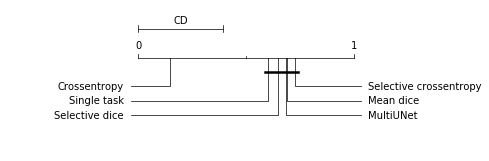

In [34]:
import Orange

def cd(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir, title, loss1, loss2):
    df = load_data(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir).rename(columns={'Unnamed: 0': 'Image'})
    counts = df.groupby('Loss function').count()['Dice']
    avranks = df.groupby('Loss function').mean()['Dice']
    names = avranks.index
    print(counts)
    print(avranks)
    print(names)
    cd = Orange.evaluation.compute_CD(avranks, 300, alpha='0.1')#, test='bonferroni-dunn')
    print(cd)
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, lowv=0, highv=1, textspace=1.5)

cd(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'smooth_metrics', 'MRBrainS13 + MRBrainS17', 'Selective crossentropy', 'MultiUNet')


# Dataset distances, dataset-wise approach

## Kolmogorov Smirnov test
To asses whether two samples come from the same distribution. 

In [6]:
from glob import glob
from scipy.stats import ks_2samp
import numpy as np

def stat_test(test, dir1, dir2=None):
    if dir2 is not None:
        paths1 = glob(dir1)[:40]
        paths2 = glob(dir2)[:40]
    else:
        paths1 = glob(dir1)
        mid = len(paths1) // 2
        paths2 = paths1[mid:]
        paths1 = paths1[:mid]
    
    ds = []
    for p in paths1:
        d = np.load(p)['data'][..., 0]
        d = d[d != -4]
        ds.append(d)
    data1 = np.concatenate(ds)
    ds = []
    for p in paths2:
        d = np.load(p)['data'][..., 0]
        d = d[d != -4]
        ds.append(d)
    data2 = np.concatenate(ds)
    del ds
    stat = (test(data1, data2))
    del data1
    del data2
    return stat

def kstest(dir1, dir2=None):
    return stat_test(ks_2samp, dir1, dir2)

In [26]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*'))

Ks_2sampResult(statistic=0.020830747832427388, pvalue=0.0)


In [12]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/smooth/ibsr/*'))

Ks_2sampResult(statistic=0.07201324808438564, pvalue=0.0)


In [13]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/mrbrains17/*'))

Ks_2sampResult(statistic=0.01364896203354074, pvalue=0.0)


In [18]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/smooth/mrbrains13/*'))

Ks_2sampResult(statistic=0.012409676330449121, pvalue=0.0)


In [14]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/tumorsim/*'))

Ks_2sampResult(statistic=0.12240898710207015, pvalue=0.0)


In [15]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/brainweb/*'))

Ks_2sampResult(statistic=0.09056595885186175, pvalue=0.0)


In [17]:
print(kstest('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/brats12/*'))

Ks_2sampResult(statistic=0.13871256092727458, pvalue=0.0)


## Jensen-Shannon divergence
To measure the similarity between two probability distributions.

In [2]:
from scipy.stats import entropy

def js(data1, data2):
    nbins = 40
    rng = [-2, 2]
    p = np.histogram(data1, nbins, rng)[0]
    q = np.histogram(data2, nbins, rng)[0]
    p = p / p.sum()
    q = q / q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

def jsdiv(dir1, dir2=None):
    return stat_test(js, dir1, dir2)

In [54]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*'))

0.001282538803250102


In [56]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/smooth/mrbrains13/*'))

0.0011829282168106833


In [57]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/mrbrains17/*'))

0.0014645718483942498


In [58]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/smooth/ibsr/*'))

0.015597070328759656


In [59]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/tumorsim/*'))

0.025026023209482405


In [60]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/brainweb/*'))

0.04387334104809858


In [61]:
print(jsdiv('../../data/preprocessed_datasets/smooth/mrbrains18/*', '../../data/preprocessed_datasets/brats12/*'))

0.034057310583307236


## Heat matrix of differences
Both KS statistic and JS divergence.

In [3]:
def allstats(data1, data2):
    """Compute KS test and JS, return an array [ks stat, ks pvalue, js divergence]"""
    ks = ks_2samp(data1, data2)
    jsstat = js(data1, data2)
    return np.array([ks.statistic, ks.pvalue, jsstat])

n_stats = 3

In [4]:
dirs = ['../../data/preprocessed_datasets/smooth/mrbrains18/*',
         '../../data/preprocessed_datasets/mrbrains17/*',
         '../../data/preprocessed_datasets/smooth/mrbrains13/*',
         '../../data/preprocessed_datasets/smooth/ibsr/*',
#          '../../data/preprocessed_datasets/tumorsim/*',
#          '../../data/preprocessed_datasets/brats12/*',
#          '../../data/preprocessed_datasets/brainweb/*'
        ]
labels = ['mrbrains18', 'mrbrains17', 'mrbrains13', 'ibsr', 
#           'tumorsim', 'brats12', 'brainweb'
         ]
n_labels = len(labels)

In [7]:
metrics = np.zeros((n_labels, n_labels, n_stats))
for i in range(n_labels):
    for j in range(i, n_labels):
        print("Computing stats for", labels[i], labels[j])
        s = stat_test(allstats, dirs[i], dirs[j] if i != j else None)
        print(s)
        metrics[i, j, :] = s
        metrics[j, i, :] = s


Computing stats for mrbrains18 mrbrains18
[0.02083075 0.         0.00212348]
Computing stats for mrbrains18 mrbrains17
[0.00910181 0.         0.00024459]
Computing stats for mrbrains18 mrbrains13
[0.02290042 0.         0.00333883]
Computing stats for mrbrains18 ibsr
[0.045236   0.         0.01148601]
Computing stats for mrbrains17 mrbrains17
[0.00818638 0.         0.00048381]
Computing stats for mrbrains17 mrbrains13
[0.02387578 0.         0.00379322]
Computing stats for mrbrains17 ibsr
[0.04229758 0.         0.0101492 ]
Computing stats for mrbrains13 mrbrains13
[0.01278991 0.         0.00099686]
Computing stats for mrbrains13 ibsr
[0.04612258 0.         0.01769465]
Computing stats for ibsr ibsr
[0.00943086 0.         0.00099173]


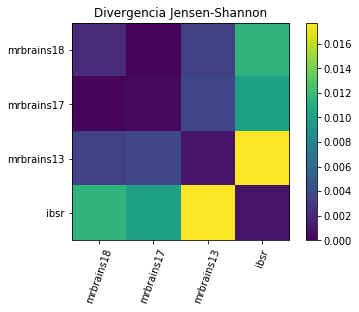

In [25]:
import matplotlib.pyplot as plt

# plt.imshow(metrics[..., 0], vmin=0, vmax=np.max(metrics[..., 0]))
# plt.xticks(range(n_labels),labels, rotation=70)
# plt.yticks(range(n_labels),labels)
# plt.title('Kolmogorov-Smirnov statistics')
# plt.colorbar()
# plt.show()

plt.imshow(metrics[..., 2], vmin=0, vmax=np.max(metrics[..., 2]))
plt.xticks(range(n_labels),labels, rotation=70)
plt.yticks(range(n_labels),labels)
plt.title('Divergencia Jensen-Shannon')
plt.colorbar()
plt.show()

# import seaborn as sns
# sns.heatmap(metrics[..., 0], xticklabels=labels, yticklabels=labels)

# Dataset distances, image-wise approach


In [2]:
from glob import glob
import numpy as np
import pandas as pd

nbins = 40
rng = [-2, 2]
def load_img_hists(dirs, labels):
    dfs = []
    for d, l in zip(dirs, labels):
        paths = glob(d)
        df = pd.DataFrame()
        df['path'] = paths
        df['label'] = l
        hists = []
        for path in paths:
            d = np.load(path)['data'][..., 0]
            d = d[d != -4]
            hists.append(np.histogram(d, nbins, rng)[0])
        df['hist'] = hists
        dfs.append(df)
    return pd.concat(dfs)

df = load_img_hists(dirs, labels)
df['key'] = 1  #for cartesian product

In [5]:
from scipy.stats import entropy
def jensen_shannon(p, q):
    p = p / p.sum()
    q = q / q.sum()
    m = (p + q) / 2
    return (entropy(p, m) + entropy(q, m)) / 2

from scipy.stats import ks_2samp
def kolmogorov_smirnov(path1, path2):
    data1 = np.load(path1)['data'][..., 0]
    data1 = data1[data1 != -4]
    data2 = np.load(path2)['data'][..., 0]
    data2 = data2[data2 != -4]
    return ks_2samp(data1, data2)

In [6]:
cart_prod = pd.merge(df, df, on='key')
cart_prod = cart_prod[cart_prod['path_x'] != cart_prod['path_y']]
cart_prod = cart_prod.drop(columns='key')
cart_prod['jensen-shannon'] = cart_prod.apply(lambda row: jensen_shannon(row['hist_x'], row['hist_y']), axis=1)
# cart_prod['kolmogorov-smirnov'] = cart_prod.apply(lambda row: kolmogorov_smirnov(row['path_x'], row['path_y']), axis=1)

In [11]:
mean_js = cart_prod.groupby(['label_x', 'label_y']).mean().reset_index()
pivot = mean_js.pivot('label_x', 'label_y', 'jensen-shannon')[labels].loc[labels]
pivot

label_y,mrbrains18,mrbrains17,mrbrains13,ibsr,tumorsim,brats12,brainweb
label_x,,,,,,,
mrbrains18,0.008242,0.007769,0.007302,0.022779,0.037862,0.031318,0.066767
mrbrains17,0.007769,0.007812,0.008903,0.022180,0.036304,0.029153,0.065955
mrbrains13,0.007302,0.008903,0.002698,0.025788,0.043856,0.037938,0.052758
ibsr,0.022779,0.022180,0.025788,0.018664,0.036166,0.029693,0.089156
tumorsim,0.037862,0.036304,0.043856,0.036166,0.019464,0.019312,0.084085
brats12,0.031318,0.029153,0.037938,0.029693,0.019312,0.013104,0.079040
brainweb,0.066767,0.065955,0.052758,0.089156,0.084085,0.079040,0.009148


In [ ]:
cart_prod['ks-stat'] = cart_prod.apply(lambda row: row['kolmogorov-smirnov'].statistic), axis=1)
cart_prod['ks-pvalue'] = cart_prod.apply(lambda row: row['kolmogorov-smirnov'].pvalue), axis=1)

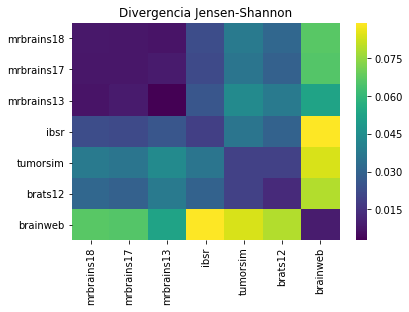

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
def heatmap(column, title):
    mean_js = cart_prod.groupby(['label_x', 'label_y']).mean().reset_index()
    # print(mean_js)
    pivot = mean_js.pivot('label_x', 'label_y', column)[labels].loc[labels]

    fig, ax = plt.subplots(1, 1)
    sns.heatmap(pivot, cmap='viridis')
    ax.set_ylabel('')    
    ax.set_xlabel('')
    plt.title(title)
    plt.show()

heatmap('jensen-shannon', 'Divergencia Jensen-Shannon')

## Histograms

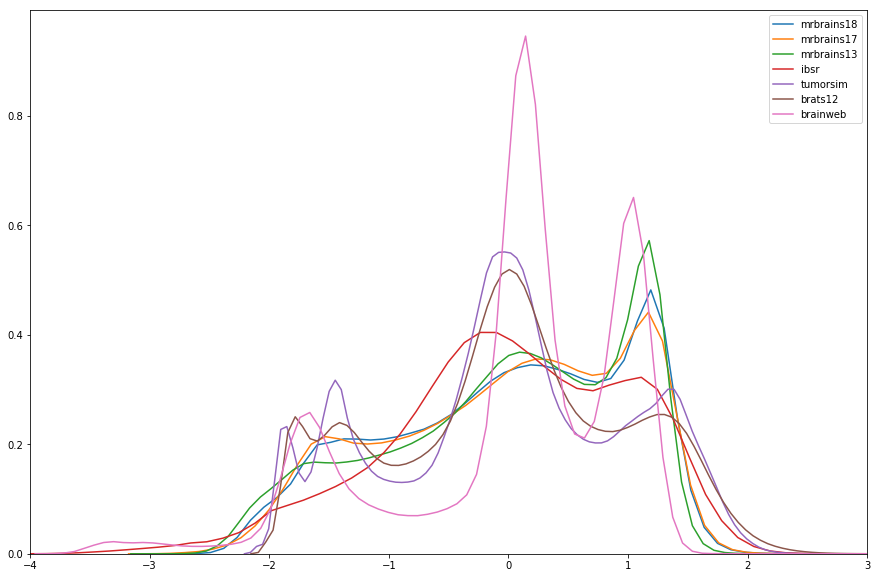

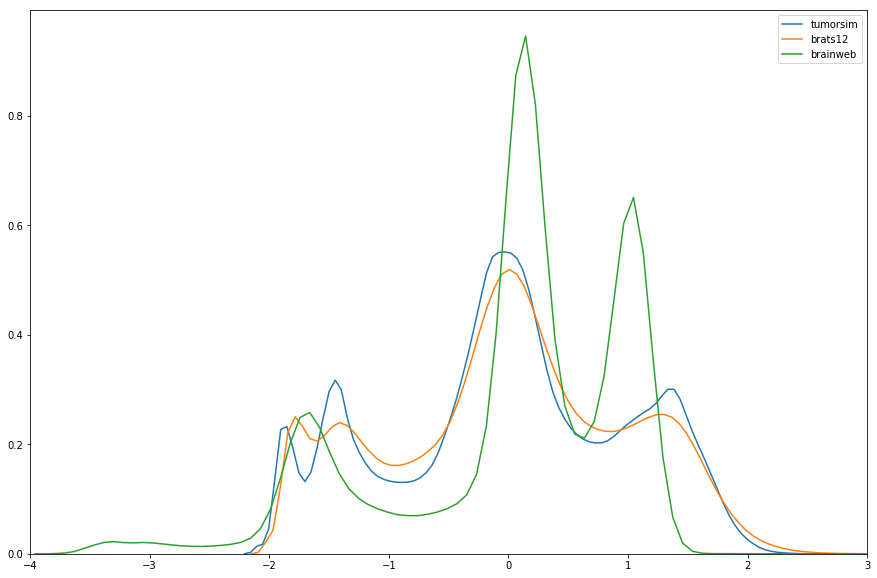

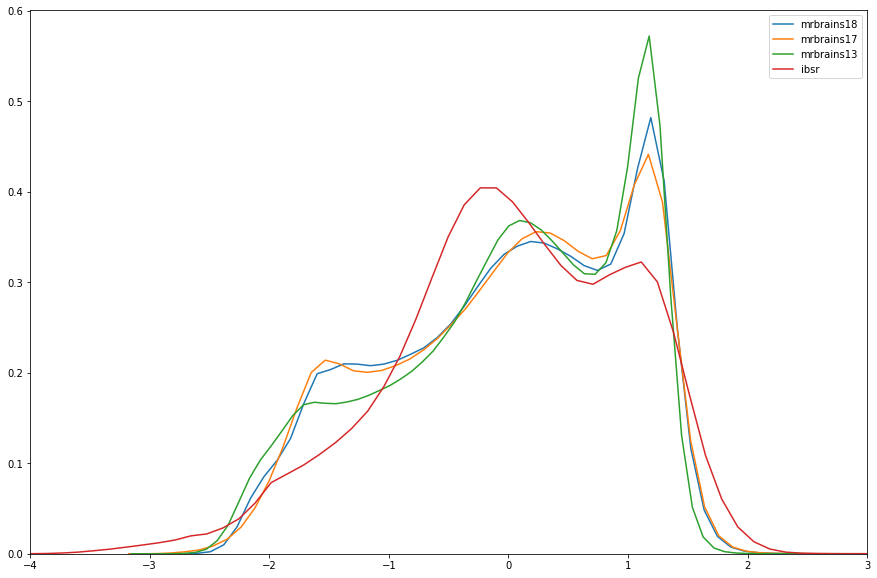

In [47]:
def hist(dir1, label, shade=False):
    paths = glob(dir1)
    ds = []
    for p in paths:
        d = np.load(p)['data'][..., 0]
        d = d[d != -4]
        ds.append(d)
    data = np.concatenate(ds)
    del ds
    g = sns.kdeplot(data, shade=shade, label=label)
    g.set(xlim=(-4, 3))

plt.figure(figsize=(15, 10))
for d, l in zip(dirs, labels):
    hist(d, l)
plt.savefig('../plots/dataset_histograms.png')
plt.show()
plt.clf()

plt.figure(figsize=(15, 10))
for d, l in zip(dirs[4:], labels[4:]):
    hist(d, l)
plt.savefig('../plots/dataset_histograms_ana+wmh.png')
plt.show()
plt.clf()

plt.figure(figsize=(15, 10))
for d, l in zip(dirs[:4], labels[:4]):
    hist(d, l)
plt.savefig('../plots/dataset_histograms_ana+tumor.png')
plt.show()
plt.clf()

# Old stuff


.

.

.

.

.

.

.

.

.









In [13]:
# Barplot version
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import Tools


def metrics_barplot(metrics_list, class_labels, method_labels, title='', savefile=''):
    n_methods = len(metrics_list)
    n_classes = len(metrics_list[0])
    colors_list = ['xkcd:midnight blue', 'xkcd:green', 'xkcd:purple', 'xkcd:blue', 'xkcd:aqua', 'xkcd:gold', 'xkcd:salmon', 'xkcd:teal', 'xkcd:khaki'][:n_methods]
#     colors_list = 'gbymrc'[:n_methods]
    plt.figure(figsize=(13, 8))

    x = []
    y = []
    colors = []
    ticks = []
    ticklabels = []
    for i, class_label in enumerate(class_labels):
        y += [metric[i] for metric in metrics_list]
        indexes = [j + i * (n_methods + 2) for j in range(n_methods)]
        x += indexes
        colors += colors_list
        ticks += [np.mean(indexes)]
        ticklabels += [class_label]
    for i, (pos, val) in enumerate(zip(x, y)):
        plt.text(s='%.2f' % val, x=pos-.5, y=val+.04, fontsize=14, rotation=45)
    plot = plt.bar(x=x,
                   height=y,
                   color=colors)
                   # tick_label=class_labels[i])
    plt.xticks(ticks, ticklabels, rotation=70)
    plt.ylim((0,1))
    plt.legend(plot[:], method_labels)
    plt.xlabel('Label')
    plt.ylabel('Dice')
    plt.title(title)
    if savefile:
        plt.savefig(savefile)
    plt.show()

def get_dice_mean_std(x):
    return (np.mean(x, axis=0)[:,3], np.std(x, axis=0)[:,3])

def plot_metrics_for_task(anatomical_dataset, lesion_dataset, multidataset, mixed_dataset, subdir, savefile=''):
    Tools.set_model_subdir(subdir)
    lesion_metrics = np.load('%s/validation_metrics.npy' % Tools.get_dataset_savedir(lesion_dataset))
    anatomical_metrics = np.load('%s/validation_metrics.npy' % Tools.get_dataset_savedir(anatomical_dataset))
    lesion_mean, lesion_std = get_dice_mean_std(lesion_metrics)
    anatomical_mean, anatomical_std = get_dice_mean_std(anatomical_metrics)
    st = np.concatenate([lesion_mean, anatomical_mean])
    st_std = np.concatenate([lesion_std, anatomical_std])

    multiunet_metrics = np.load('%s/validation_metrics.npy' % Tools.get_dataset_savedir(mixed_dataset))
    multiunet, multiunet_std = get_dice_mean_std(multiunet_metrics)

    crossentropy_metrics = np.load('%s/validation_metrics_%s.npy' % (Tools.get_dataset_savedir(multidataset), mixed_dataset.name))
    crossentropy, crossentropy_std = get_dice_mean_std(crossentropy_metrics)
    
    mean_dice_metrics = np.load('%s/validation_metrics_%s.npy' % (Tools.get_dataset_savedir(multidataset, loss=Metrics.mean_dice_loss), mixed_dataset.name))
    mean_dice, mean_dice_std = get_dice_mean_std(mean_dice_metrics)

    selective_dice_metrics = np.load('%s/validation_metrics_%s.npy' % (Tools.get_dataset_savedir(multidataset, loss=Metrics.selective_dice_loss), mixed_dataset.name))
    selective_dice, selective_dice_std = get_dice_mean_std(selective_dice_metrics)

    selective_crossentropy_metrics = np.load('%s/validation_metrics_%s.npy' % (Tools.get_dataset_savedir(multidataset, loss=Metrics.selective_sparse_categorical_crossentropy), mixed_dataset.name))
    selective_crossentropy, selective_crossentropy_std = get_dice_mean_std(selective_crossentropy_metrics)

#     improved_selective_crossentropy_metrics = np.load('../models/unet_%s_%s_improved_selective_sparse_categorical_crossentropy/validation_metrics_%s.npy' % (lesion_dataset.name, 
#                                                                                                                                                         anatomical_dataset.name, mixed_dataset.name))
#     improved_selective_crossentropy, improved_selective_crossentropy_std = get_dice_mean_std(improved_selective_crossentropy_metrics)

    metrics_barplot([st, multiunet, crossentropy, selective_crossentropy, mean_dice, selective_dice],
                    ['WMH', 'CSF', 'GM', 'WM'],
                    ('Single task', 'MultiUNet', 'Crossentropy', 'Selective crossentropy', 'Mean dice', 'Selective dice'),
                    title='%s + %s' % (lesion_dataset.name, anatomical_dataset.name), savefile=savefile)


## WMH

### WMH: MRBrainS17 and MRBrainS13

Different networks trained on MRBrainS17 and MRBrainS13 and validated on MRBrainS18.

#### Old normalization metrics (divide by std):

old_normalization_metrics


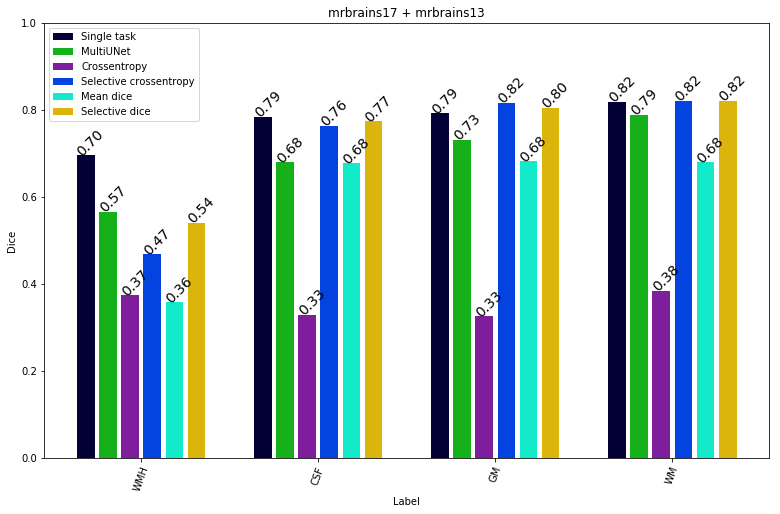

In [36]:
plot_metrics_for_task(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'old_normalization_metrics', savefile='../plots/mrbrains17_ibsr_old_normalization_metrics_barplot.png')
# plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'old_normalization_metrics')


#### Samples are drawn equiprobably between datasets:

balanced_datasets_metrics


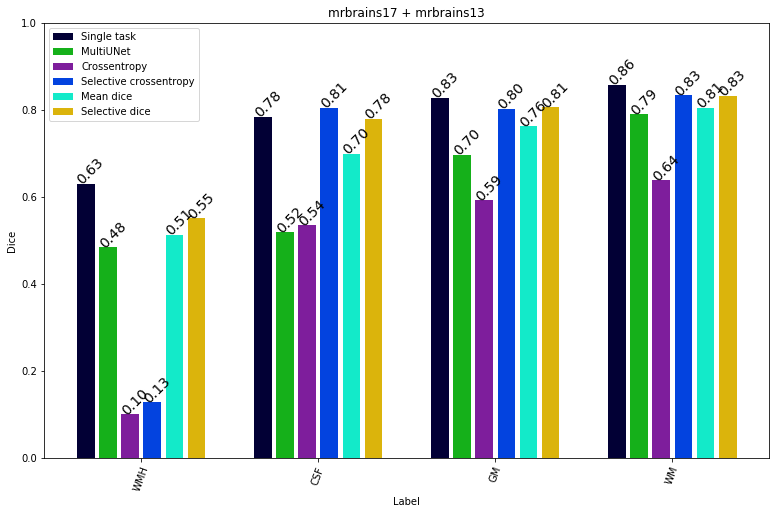

In [35]:
# plot_metrics_for_task(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'balanced_datasets_metrics', savefile='../plots/mrbrains17_13_metrics_barplot.png')
plot_metrics_for_task(mrbrains13, mrbrains17, mrbrains17_13, mrbrains18, 'balanced_datasets_metrics')

### WMH: MRBrainS17 and IBSR

Different networks trained on MRBrainS17 and IBSR and validated on MRBrainS18.

#### Old normalization metrics (divide by std):

old_normalization_metrics


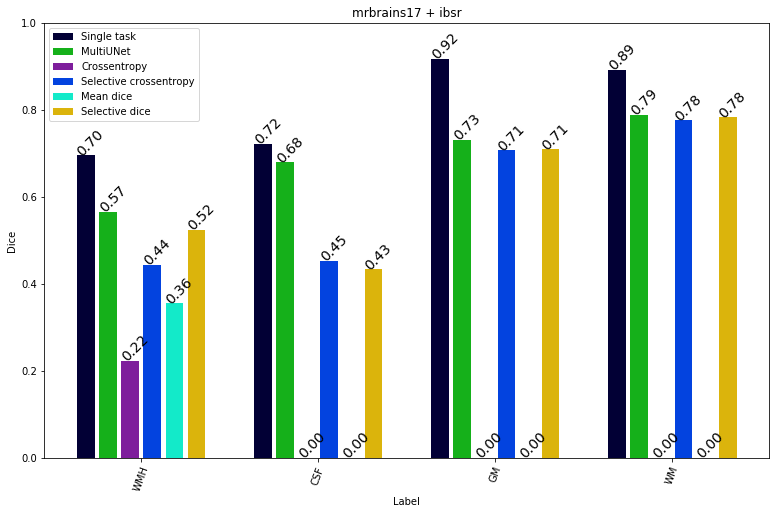

In [34]:
plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'old_normalization_metrics', savefile='../plots/mrbrains17_ibsr_old_normalization_metrics_barplot.png')
# plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'old_normalization_metrics')


#### Samples are drawn equiprobably between datasets:

balanced_datasets_metrics


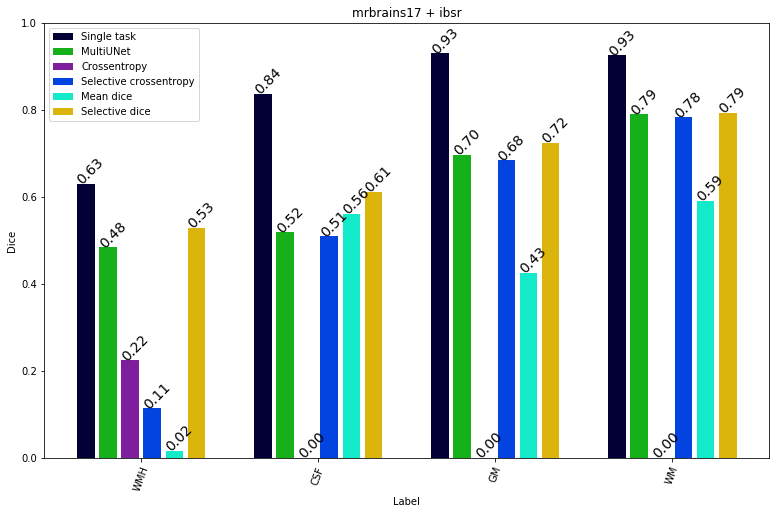

In [31]:
plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'balanced_datasets_metrics', savefile='../plots/mrbrains17_ibsr_metrics_barplot.png')
# plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'balanced_datasets_metrics')


Samples are drawn equiprobably between labels:

balanced_labels_metrics


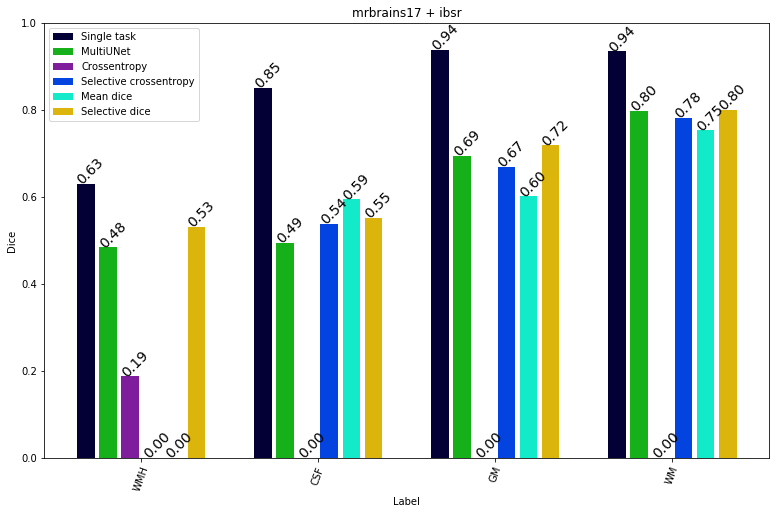

In [15]:
plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'balanced_labels_metrics', savefile='../plots/mrbrains17_ibsr_labels_metrics_barplot.png')
# plot_metrics_for_task(ibsr, mrbrains17, mrbrains17_ibsr, mrbrains18, 'balanced_labels_metrics')


# Random stuff

In [1]:
import Datasets
import matplotlib.pyplot as plt

brats = Datasets.BraTS()
gen = brats.get_val_generator(1)

X, Y = next(gen.generate_batches(1))
bbox = gen.get_bounding_box(X)
print(bbox)



/home/nico/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(55, 187, 31, 195, 0, 139)


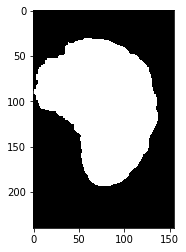

(240, 155)
[ 16.499792  26.488352  26.640045  72.93048   75.357605 130.52805
 127.68085  129.6529   108.578896 101.915955  93.1293   100.188995
  92.02076  104.226395 102.67445  114.07496  119.81601  116.85213
 118.70749  121.05294  125.63882  128.39267  132.66347  138.38123
 145.42926  156.0129   163.08426  169.87552  169.38544  175.79164
 179.5607   181.87112  185.26674  191.56796  197.39069  217.54285
 220.62346  225.74606  237.56668  242.4676   243.77444  244.42793
 244.5796   244.0545   247.20512  268.40753  268.0457   263.3899
 265.7003   271.20804  278.76947  288.61798  307.8016   347.27747
 384.1278   404.04648  421.58478  434.3739   451.31705  462.88098
 471.57446  478.92566  489.06607  496.11392  502.75363  509.3464
 517.6314   523.5824   526.58136  523.0224   517.01294  510.8751
 499.56787  491.1431   484.1417   476.6037   466.27664  454.00095
 438.9832   426.7308   413.63846  407.24374  405.84354  402.65802
 406.25198  411.1996   408.95905  413.35852  414.24515  418.77283
 

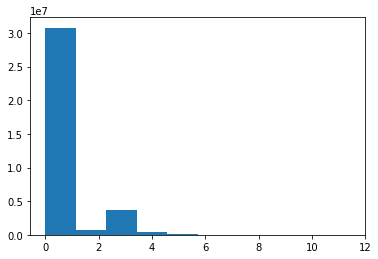

30394906
30391971


In [2]:
import numpy as np
plt.imshow(X[0,110,...,1] != 0, cmap='gray')
plt.show()
slice = X[0,110,...,1]
print(slice.shape)
print(np.sum(slice, axis=0))
plt.hist(X.flat)
plt.show()

print(np.sum(X < 0.1))
print(np.sum(X < 0.001))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Datasets
data = np.load('checkpoints/unet_brats_4/metrics.npy')
print(data.shape)
n_epochs, n_classes, n_metrics = data.shape
assert(n_classes == Datasets.BraTS.n_classes - 1)

metrics = ['accuracy', 'sensitivity', 'specificity', 'dice', 'jaccard', 'hausdorff', 
           'contour mean distance'][:n_metrics]

classes = ['Cerebrospinal fluid',
           'Gray matter',
           'White matter']

data = data.reshape(n_epochs, n_classes * n_metrics)
print(data.shape)
cols = pd.MultiIndex.from_product([classes, metrics])
print(cols)
df = pd.DataFrame(data, columns=cols, index=range(10))

# df['Gray matter'].plot()
df[[(cls, 'dice') for cls in classes]].plot()

# df.plot(('Gray matter', 'accuracy'), label='accuracy')
# df.plot(('Gray matter', 'dice'), label='dice')
plt.show()

[[[[0.99664677 0.2382904  0.99821162 0.2264067  0.12765424]
   [0.99603998 0.64005283 0.99711564 0.49336747 0.32746371]
   [1.                nan 1.                nan        nan]
   [0.99895833 0.88680305 0.99912714 0.71900611 0.5612877 ]]]]
(1, 1, 4, 5)


ValueError: too many values to unpack (expected 3)

## ATLAS

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import Datasets
data = np.load('checkpoints/unet_atlas_4/metrics.npy')

print(np.append(data, data, axis=0))
print(data.shape)
n_epochs, n_classes, n_metrics = data.shape
assert(n_classes == Datasets.ATLAS.n_classes - 1)

metrics = ['accuracy', 'sensitivity', 'specificity', 'dice', 'jaccard', 'hausdorff', 
           'contour mean distance'][:n_metrics]

classes = ['Stroke lesion']

data = data.reshape(n_epochs, n_classes * n_metrics)
print(data.shape)
cols = pd.MultiIndex.from_product([classes, metrics])
print(cols)
df = pd.DataFrame(data, columns=cols, index=range(10))

# df['Gray matter'].plot()
df[[(cls, 'dice') for cls in classes]].plot()

# df.plot(('Gray matter', 'accuracy'), label='accuracy')
# df.plot(('Gray matter', 'dice'), label='dice')
plt.show()

[[[[0.99542487 0.00892932 0.9985582  0.01220799 0.00614148]]]


 [[[0.9932938  0.03493634 0.99872415 0.05545011 0.02851565]]]


 [[[0.99118016 0.01115248 0.99860791 0.01866796 0.00942192]]]


 [[[0.99783457 0.03542617 0.9985601  0.02405478 0.01217381]]]


 [[[0.99712421 0.0338835  0.99858361 0.03442158 0.01751219]]]


 [[[0.99542487 0.00892932 0.9985582  0.01220799 0.00614148]]]


 [[[0.9932938  0.03493634 0.99872415 0.05545011 0.02851565]]]


 [[[0.99118016 0.01115248 0.99860791 0.01866796 0.00942192]]]


 [[[0.99783457 0.03542617 0.9985601  0.02405478 0.01217381]]]


 [[[0.99712421 0.0338835  0.99858361 0.03442158 0.01751219]]]]
(5, 1, 1, 5)


ValueError: too many values to unpack (expected 3)

## WMH

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

metrics = pd.read_csv('checkpoints/unet_mrbrains17_4/metrics.csv')
full_volume_metrics = np.load('checkpoints/unet_mrbrains17_4/full_volume_metrics.npz')

In [26]:
full_volume_metrics['val']

array([0.99828321, 0.0668164 , 0.99843213, 0.01229021, 0.0061831 ,
       0.99822533, 0.91206067, 0.99861344, 0.82171742, 0.6973857 ,
       0.99923293, 0.76328362, 0.999597  , 0.75405779, 0.60521088,
       0.99834711, 0.86263547, 0.99906517, 0.84600387, 0.73310807,
       0.99936164, 0.88207823, 0.99950608, 0.77269241, 0.62958333,
       0.99849454, 0.91676087, 0.99888517, 0.85279051, 0.74336075,
       0.99983001, 0.81003584, 0.99984916, 0.49023861, 0.32471264,
       0.99937727, 0.90650296, 0.99946392, 0.73071848, 0.57569456])

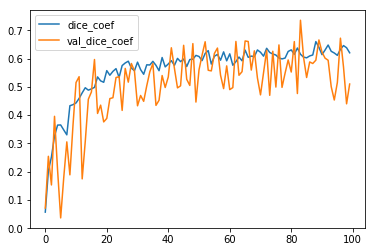

In [6]:
ax = plt.subplot(111)
metrics.plot(ax=ax, y='dice_coef')
metrics.plot(ax=ax, y='val_dice_coef')
# metrics.plot('val_dice_coef')
plt.show()

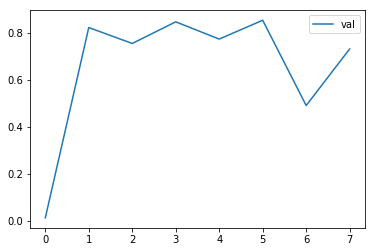

In [28]:
# plt.plot(full_volume_metrics['train'][:,3], label='train')
plt.plot(full_volume_metrics['val'][3::5], label='val')
plt.legend()
plt.show()